# 川普上任後臺灣民眾之相關看法分析

第21組
組員：B104020019 黃婕妮
、B104020023 蔡宜樺（組長）
、B104020027 蕭宇廷
、B104020028 林晏甄

影片連結：https://www.youtube.com/watch?v=CHK0VUYZrVk

# 大綱



1.   資料前處理
2.   主題模型
3.   embedding尋找相似詞、文章
4.   BERT實作NER分析
5. 網路圖



# 1. 資料前處理

## 引入相關套件及繁體中文字體設定

In [ ]:
# !pip install jieba
# !pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 7.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import matplotlib.font_manager as fm
from wordcloud import WordCloud

from collections import Counter

import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-06-15 10:47:52--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.152.139, 142.250.152.138, 142.250.152.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.152.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-15 10:47:52--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.183.132, 2607:f8b0:4001:c64::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.183.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  74.5MB/s    in 0.3s    

2025-06-15 

## 引入資料集

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 資料集為PTT的股票版，時間為4/1-5/28，總共有3165筆資料

In [ ]:
## 讀取從ptt爬下來的評論資料
df = pd.read_csv('/content/drive/MyDrive/project/sna2025s_7_c3661dc516_4.csv')
df

system_id                                             artUrl  \
0             1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1             2  https://www.ptt.cc/bbs/Stock/M.1743468064.A.F2...   
2             3  https://www.ptt.cc/bbs/Stock/M.1743469067.A.DB...   
3             4  https://www.ptt.cc/bbs/Stock/M.1743470927.A.6F...   
4             5  https://www.ptt.cc/bbs/Stock/M.1743478898.A.43...   
...         ...                                                ...   
3160       3161  https://www.ptt.cc/bbs/Stock/M.1748315181.A.5C...   
3161       3162  https://www.ptt.cc/bbs/Stock/M.1748338010.A.F5...   
3162       3163  https://www.ptt.cc/bbs/Stock/M.1748345695.A.08...   
3163       3164  https://www.ptt.cc/bbs/Stock/M.1748356404.A.EF...   
3164       3165  https://www.ptt.cc/bbs/Stock/M.1748364059.A.28...   

                                artTitle              artDate    artPoster  \
0     Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19       utn875   
1                [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02         rz2x   
2                [新聞]年賺11%！　達人揭「最強3檔ETF」  2025-04-01 08:57:45     galeolow   
3             Re:[新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 09:28:45      myIDis7   
4                  [新聞]川普對等關稅失算？謝金河分析最開心  2025-04-01 11:41:36  davidaustin   
...                                  ...                  ...          ...   
3160               [新聞]繼台積電與美4大廠後美國半導體協會  2025-05-27 11:06:18    kobebrian   
3161             [新聞]川普關稅、匯率雙衝擊　專家示警：下半年  2025-05-27 17:26:47    troy30408   
3162             [新聞]外資變臉賣超102億元調節聯電逾4萬張  2025-05-27 19:34:51       STAV72   
3163               [新聞]黃仁勳被帶去中東！謝金河曝川普盤算  2025-05-27 22:33:12    loveoichi   
3164              [新聞]專家稱川普核能政策將推高鈾價刺激投資  2025-05-28 00:40:56    TyuzuChou   

     artCatagory                                         artContent  \
0          Stock  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
1          Stock  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   
2          Stock  原文標題：\n\n年賺11%！　達人揭「最強3檔ETF」\n\n原文連結：\nhttps:/...   
3          Stock  骯髒15國本來就不是川普講的\n\n骯髒15國（the dirty 15），是美國財政部長貝...   
4          Stock  原文標題：\n川普對等關稅失算？謝金河分析最開心的是大陸 尷尬真相曝光\n\n原文連結：\n...   
...          ...                                                ...   
3160       Stock  原文標題：\n\n繼台積電與美 4 大廠後，美國半導體協會也出手呼籲川普勿徵關稅\n\n\n...   
3161       Stock  原文標題：川普關稅、匯率雙衝擊　專家示警：下半年恐掀倒閉潮\n原文連結：\nhttps://...   
3162       Stock  原文標題：\n外資變臉賣超102億元 調節聯電逾4萬張\n\n原文連結：\nhttps://...   
3163       Stock  原文標題：\n黃仁勳被帶去中東！謝金河曝川普盤算\n\n原文連結：\nhttps://reu...   
3164       Stock  原文標題：\nTrump's nuclear energy orders would boo...   

                                             artComment             e_ip  \
0     [{"cmtStatus": "噓", "cmtPoster": "FK6819", "cm...    111.71.82.129   
1     [{"cmtStatus": "推", "cmtPoster": "suzu1", "cmt...    61.220.173.25   
2     [{"cmtStatus": "噓", "cmtPoster": "Kobe5210", "...    36.230.61.187   
3     [{"cmtStatus": "→", "cmtPoster": "HelloLadies"...     1.200.27.188   
4     [{"cmtStatus": "推", "cmtPoster": "Sweet83921",...     180.177.0.97   
...                                                 ...              ...   
3160  [{"cmtStatus": "推", "cmtPoster": "realmd", "cm...     49.218.138.4   
3161  [{"cmtStatus": "推", "cmtPoster": "Roger5566", ...     60.250.89.91   
3162  [{"cmtStatus": "推", "cmtPoster": "lucky466", "...   59.124.203.223   
3163  [{"cmtStatus": "推", "cmtPoster": "OAO5566", "c...  111.250.197.173   
3164  [{"cmtStatus": "推", "cmtPoster": "devidevi", "...  150.117.197.145   

             insertedDate dataSource  
0     2025-04-01 01:35:07        ptt  
1     2025-04-04 19:29:49        ptt  
2     2025-04-04 19:29:49        ptt  
3     2025-04-04 19:29:49        ptt  
4     2025-04-04 19:29:54        ptt  
...                   ...        ...  
3160  2025-05-28 01:33:42        ptt  
3161  2025-05-28 01:33:53        ptt  
3162  2025-05-28 01:33:53        ptt  
3163  2025-05-28 01:33:53        ptt  
3164  2025-05-28 01:33:56        

In [ ]:
clear_df = df.copy()

#去除本次不會用到的欄位
drop_cols = ['system_id', 'artUrl', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource']
clear_df.drop(drop_cols, axis = 1, inplace = True)

#去除文章內容為空值的筆數
clear_df.dropna(subset = ['artContent'], axis=0, how='any', inplace=True)

#新增['sentence']欄位，用'。'取代'\n\n'，並移除'\n'
clear_df['sentence'] = clear_df['artContent'].str.replace(r'\n\n','。', regex=True)
clear_df['sentence'] = clear_df['sentence'].str.replace(r'\n','，', regex=True)

#移除內文中的網址
clear_df['sentence'] = clear_df['sentence'].replace(r'http\S+', '', regex=True).replace(r'www\S+', '', regex=True)

clear_df.head(10)

artTitle              artDate  \
0   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1              [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02   
2              [新聞]年賺11%！　達人揭「最強3檔ETF」  2025-04-01 08:57:45   
3           Re:[新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 09:28:45   
4                [新聞]川普對等關稅失算？謝金河分析最開心  2025-04-01 11:41:36   
5                [新聞]謝金河：最怕川普打斷美國三條腿台股  2025-04-01 12:43:05   
6               [新聞]川普又讚台積電「很精明」！突脫口爆：  2025-04-01 12:48:01   
7  [新聞]3月財新中國製造業PMI錄得51.2，創2024年12月來新高  2025-04-01 13:13:50   
8                               [創作]泡沫  2025-04-01 14:00:13   
9               [新聞]川普對等關稅引發擔憂學者警惕關注通縮  2025-04-01 16:03:28   

                                          artContent  \
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
1  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   
2  原文標題：\n\n年賺11%！　達人揭「最強3檔ETF」\n\n原文連結：\nhttps:/...   
3  骯髒15國本來就不是川普講的\n\n骯髒15國（the dirty 15），是美國財政部長貝...   
4  原文標題：\n川普對等關稅失算？謝金河分析最開心的是大陸 尷尬真相曝光\n\n原文連結：\n...   
5  謝金河：最怕川普打斷美國三條腿 台股面臨對等關稅衝擊\n\n2025-04-01 12:09...   
6  原文標題：\n\n川普又讚台積電「很精明」！ 突脫口爆：擬投資2000─3000億美元\n\...   
7  原文標題：3月財新中國製造業PMI錄得51.2，創2024年12月來新高\n原文連結：\nh...   
8  https://www.youtube.com/watch?v=GHXr4bBxHCo&ab...   
9  原文標題：\n川普對等關稅引發擔憂 學者警惕關注通縮\n原文連結：\nhttps://www...   

                                            sentence  
0  為何蓋廠投資額，相比蓋N3廠省一半???，答案很簡單，就是高雄五座廠只會用一半。這篇講了五座...  
1  原文標題：，稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率。原文連結：， ...  
2  原文標題：。年賺11%！　達人揭「最強3檔ETF」。原文連結：， 07:21。記者署名：。E...  
3  骯髒15國本來就不是川普講的。骯髒15國（the dirty 15），是美國財政部長貝森特（...  
4  原文標題：，川普對等關稅失算？謝金河分析最開心的是大陸 尷尬真相曝光。原文連結：， 2025...  
5  謝金河：最怕川普打斷美國三條腿 台股面臨對等關稅衝擊。2025-04-01 12:09 聯合...  
6  原文標題：。川普又讚台積電「很精明」！ 突脫口爆：擬投資2000─3000億美元。原文連結：...  
7  原文標題：3月財新中國製造業PMI錄得51.2，創2024年12月來新高，原文連結：， 11...  
8   - 泡沫。螢幕上的均線是彩色的 就像被套的我是幸福的，追著正二做多 不怕軍演 基於國安做多...  
9  原文標題：，川普對等關稅引發擔憂 學者警惕關注通縮，原文連結：， 11:56，記者署名：，張...

## 斷句
中文主要以標點符號進行斷句，並清除空的字串

In [ ]:
clear_df['sentence'] = clear_df['sentence'].str.split("[,，。！!？?]{1,}")

sent_df = clear_df.explode('sentence').reset_index(drop=True)

sent_df.head(10)

artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
4  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
5  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
6  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
7  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
8  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
9             [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02   

                                          artContent             sentence  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...              為何蓋廠投資額  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...            相比蓋N3廠省一半  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                答案很簡單  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...         就是高雄五座廠只會用一半  
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  這篇講了五座廠無塵室面積28萬平方公尺  
5  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...             這如果全部做N2  
6  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...            月產能可達37萬片  
7  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...         怎可能只花1.5兆就搞定  
8  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                       
9  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...                原文標題：

In [ ]:
# 初始化斷詞引擎：不一定要設定，只使用內建效果也可以
# 參考網址：https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
jieba.set_dictionary('/content/drive/MyDrive/project/dict/dict.txt')

In [ ]:
#去除句子中除了字母、數字、空白字符以外的符號
sent_df['sentence'] = sent_df['sentence'].str.replace(r'[^\w\s]+', '', regex=True).astype(str)

# 把長度小於1的sentence刪掉
sent_df = sent_df[sent_df["sentence"].str.len() > 1]

sent_df.head(10)

artTitle              artDate  \
0   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
4   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
5   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
6   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
7   Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
9              [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02   
10             [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02   

                                           artContent  \
0   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
1   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
2   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
3   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
4   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
5   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
6   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
7   為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
9   原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   
10  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   

                        sentence  
0                        為何蓋廠投資額  
1                      相比蓋N3廠省一半  
2                          答案很簡單  
3                   就是高雄五座廠只會用一半  
4            這篇講了五座廠無塵室面積28萬平方公尺  
5                       這如果全部做N2  
6                      月產能可達37萬片  
7                    怎可能只花15兆就搞定  
9                           原文標題  
10  稱沒聽過骯髒15國 川普對等關稅再變 擬無差別課20稅率

In [ ]:
word_df = sent_df.assign(word = sent_df['sentence'].apply(jieba.lcut)).explode('word').drop(['sentence'], axis=1)

# 去除空值
word_df = word_df.dropna(subset=['word'])

# word_df = word_df.loc[word_df['word'].str.len() > 1]

word_df.head(10)

Building prefix dict from /content/drive/MyDrive/project/dict/dict.txt ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/project/dict/dict.txt ...
Loading model from cache /tmp/jieba.ue19a183bcba5d3822e0322985453744f.cache
DEBUG:jieba:Loading model from cache /tmp/jieba.ue19a183bcba5d3822e0322985453744f.cache
Loading model cost 0.533 seconds.
DEBUG:jieba:Loading model cost 0.533 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent word  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   為何  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   蓋廠  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  投資額  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   相比  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...    蓋  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   N3  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   廠省  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   一半  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   答案  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...    很

In [ ]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()
freq_df.head(10)

word  count
0       61734
1    的  33763
2   美國  12854
3   關稅  10472
4    是   9579
5   川普   9513
6    在   8258
7    了   5738
8    也   5287
9   中國   4971

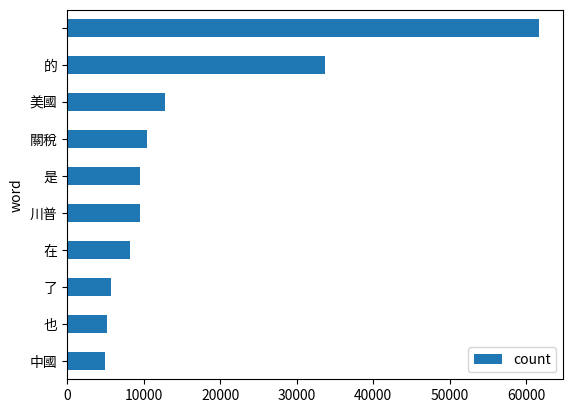

In [ ]:
freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

In [ ]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

print(dict(list(freq_dict.items())[:10]))

{' ': 61734, '的': 33763, '美國': 12854, '關稅': 10472, '是': 9579, '川普': 9513, '在': 8258, '了': 5738, '也': 5287, '中國': 4971}


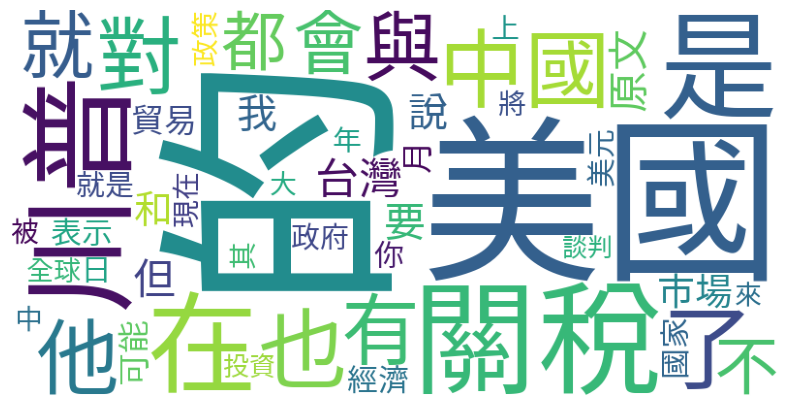

In [ ]:
font_path = 'TaipeiSansTCBeta-Regular.ttf'

# 繪製文字雲
wordcloud = WordCloud(background_color = 'white', width = 800, height = 400,  font_path=font_path, max_words = 50)
wordcloud.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#去除少於兩個字的詞語
word_df = word_df.loc[word_df['word'].str.len() > 1]

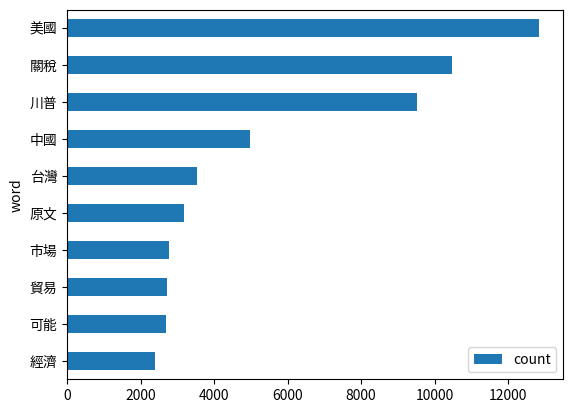

In [ ]:
freq_df = pd.DataFrame(word_df['word'].value_counts()).sort_values(by = ['count'], ascending = False).reset_index()

freq_df.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()

plt.show()

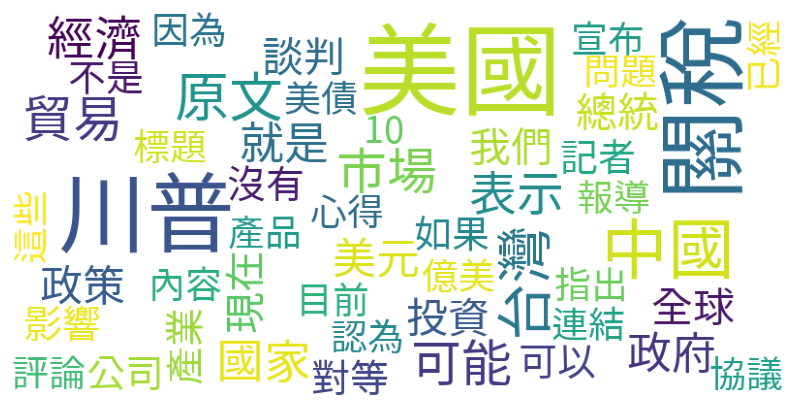

In [ ]:
# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict = freq_df.set_index('word').to_dict()
freq_dict = freq_dict['count']

# 繪製文字雲
wordcloud_no1 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50)
wordcloud_no1.generate_from_frequencies(freq_dict)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.show()

In [ ]:
# 以檔案形式匯入通用的停用字檔案
# 將stopwords存成list
stopwords = [line.strip() for line in open('/content/drive/MyDrive/project/dict/stopwords.txt', 'r', encoding='utf-8').readlines()]

In [ ]:
noStop_df = word_df[~word_df['word'].isin(stopwords)]

noStop_df.head(10)

artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent word  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   蓋廠  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  投資額  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   相比  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   N3  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   廠省  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   一半  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   答案  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   簡單  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   高雄  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   五座

<ipython-input-19-583685406>:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()


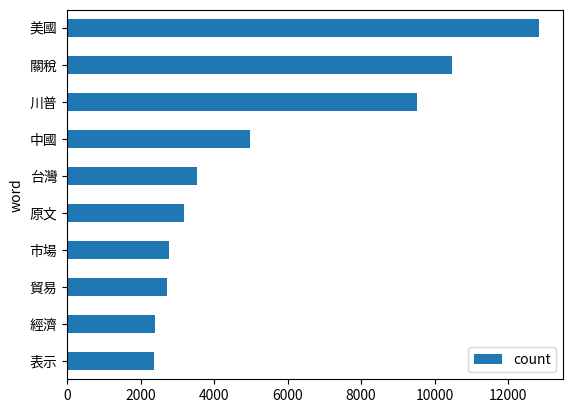

In [ ]:
freq_df_nostop = pd.DataFrame(pd.value_counts(noStop_df['word'])).sort_values(by = ['count'], ascending = False).reset_index()

freq_df_nostop.head(10).plot.barh(x = 'word', y = 'count').invert_yaxis()
plt.show()

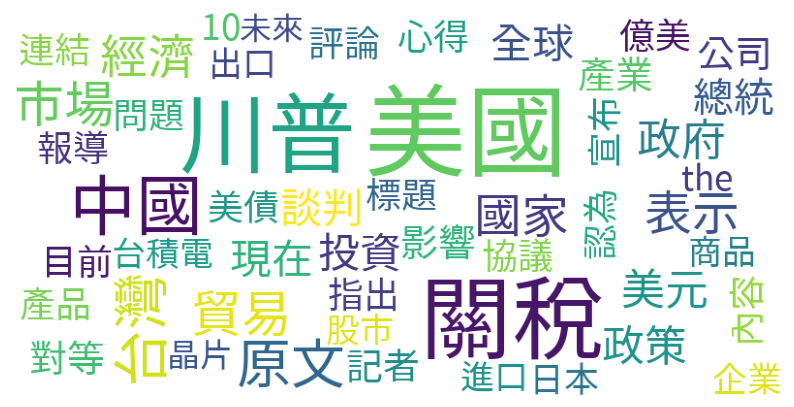

In [ ]:
freq_dict_nostop = freq_df_nostop.set_index('word').to_dict()
freq_dict_nostop = freq_dict_nostop['count']

# 繪製文字雲
wordcloud_nostop = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50)
wordcloud_nostop.generate_from_frequencies(freq_dict_nostop)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.show()

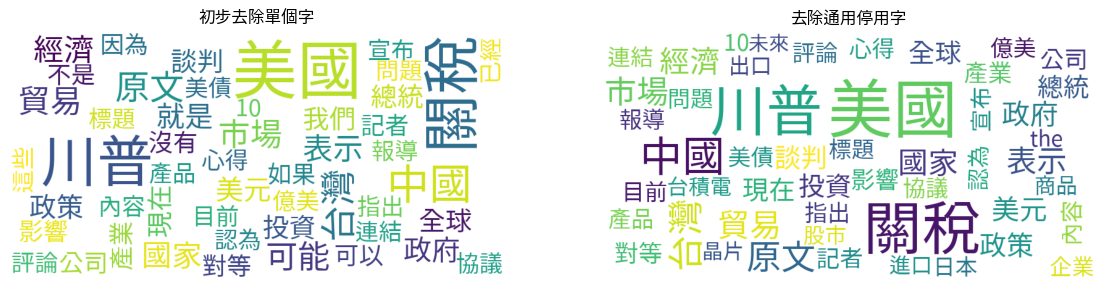

In [ ]:
plt.figure(figsize = (14,8))

plt.subplot(1,2,1)
plt.imshow(wordcloud_no1)
plt.axis('off')
plt.title("初步去除單個字")

plt.subplot(1,2,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除通用停用字")

plt.show()

## 更新停用字字典

In [ ]:
# 參數形式手動加入停用字
stopwords_manual = ["億美", "心得", "內容", "原文", "表示", "未來", "評論", "連結", "目前", "標題", "指出", "10", "the", "問題", "商品", "企業", "記者", "措施", "認為", "現在", "20"]
stopwords.extend(stopwords_manual)



  ## 斷詞好的df在這裡，noStop_df_2

In [ ]:
noStop_df_2 = noStop_df[~noStop_df['word'].isin(stopwords)]
noStop_df_2.head(10)

artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent word  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   蓋廠  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  投資額  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   相比  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   N3  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   廠省  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   一半  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   答案  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   簡單  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   高雄  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   五座

<ipython-input-24-229226756>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()


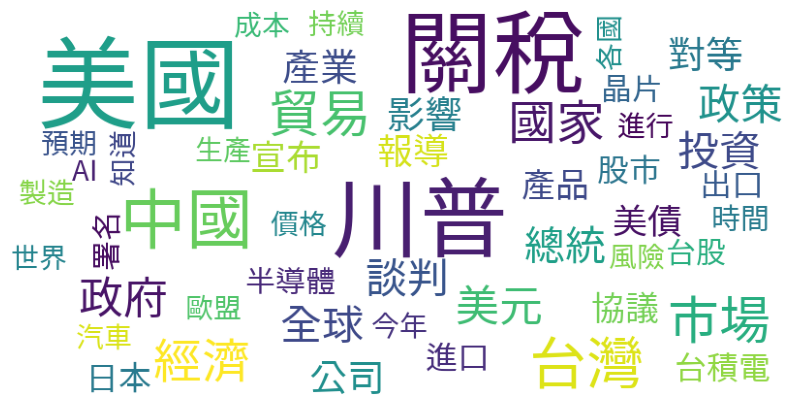

In [ ]:
# 計算詞頻
freq_df_nostop_2 = pd.DataFrame(pd.value_counts(noStop_df_2['word'])).sort_values(by = ['count'], ascending = False).reset_index()

# wordcloud的輸入須為dict，因此先將freq_df轉換成成dict
freq_dict_nostop_2 = freq_df_nostop_2.set_index('word').to_dict()
freq_dict_nostop_2 = freq_dict_nostop_2['count']

# 繪製文字雲
wordcloud_nostop_2 = WordCloud(background_color = 'white', width = 800, height = 400, font_path = font_path, max_words = 50)
wordcloud_nostop_2.generate_from_frequencies(freq_dict_nostop_2)

plt.figure(figsize = (10,7))
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.show()

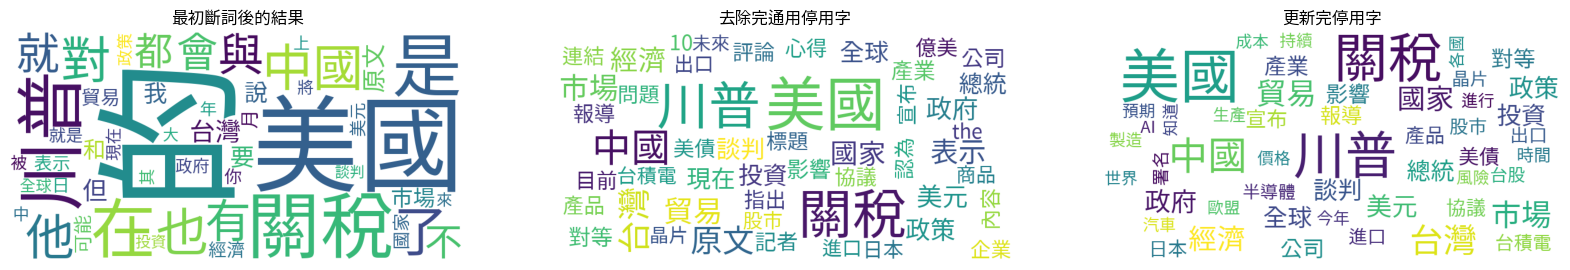

In [ ]:
plt.figure(figsize = (20,14))

plt.subplot(1,3,1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("最初斷詞後的結果")

plt.subplot(1,3,2)
plt.imshow(wordcloud_nostop)
plt.axis('off')
plt.title("去除完通用停用字")

plt.subplot(1,3,3)
plt.imshow(wordcloud_nostop_2)
plt.axis('off')
plt.title("更新完停用字")

plt.show()

## 情緒分析

In [ ]:
# 讀取情緒字典
liwc_dict = pd.read_csv("/content/drive/MyDrive/project/dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

word sentiments
0   ):     affect
1   3q     affect
2   :(     affect
3   :)     affect
4   <3     affect

In [ ]:
ptt_liwc_df = pd.merge(noStop_df_2[["artDate", "artTitle", "artContent", "word"]], liwc_dict, how="left")
ptt_liwc_df.head()

artDate                            artTitle  \
0  2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
1  2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
2  2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
3  2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
4  2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   

                                          artContent word sentiments  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   蓋廠        NaN  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  投資額        NaN  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   相比        NaN  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   N3        NaN  
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   廠省        NaN

In [ ]:
ptt_liwc_df["artDate"] = pd.to_datetime(ptt_liwc_df["artDate"])
ptt_liwc_df["date"] = ptt_liwc_df["artDate"].dt.date
ptt_liwc_df.head(10)

artDate                            artTitle  \
0 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
1 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
2 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
3 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
4 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
5 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
6 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
7 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
8 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
9 2025-04-01 00:10:19  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   

                                          artContent word sentiments  \
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   蓋廠        NaN   
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  投資額        NaN   
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   相比        NaN   
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   N3        NaN   
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   廠省        NaN   
5  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   一半        NaN   
6  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   答案        NaN   
7  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   簡單     affect   
8  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   簡單   positive   
9  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   高雄        NaN   

         date  
0  2025-04-01  
1  2025-04-01  
2  2025-04-01  
3  2025-04-01  
4  2025-04-01  
5  2025-04-01  
6  2025-04-01  
7  2025-04-01  
8  2025-04-01  
9  2025-04-01

### 計算合併後的詞頻

In [ ]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["date", "sentiments"]).size()
).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["date"])
sentiment_count.head(10)

date sentiments  size
3   2025-04-01   negative   110
4   2025-04-01   positive   102
9   2025-04-02   negative    39
10  2025-04-02   positive    39
15  2025-04-03   negative   426
16  2025-04-03   positive   358
21  2025-04-04   negative   633
22  2025-04-04   positive   613
27  2025-04-05   negative   504
28  2025-04-05   positive   518

In [ ]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

### 繪製折線圖

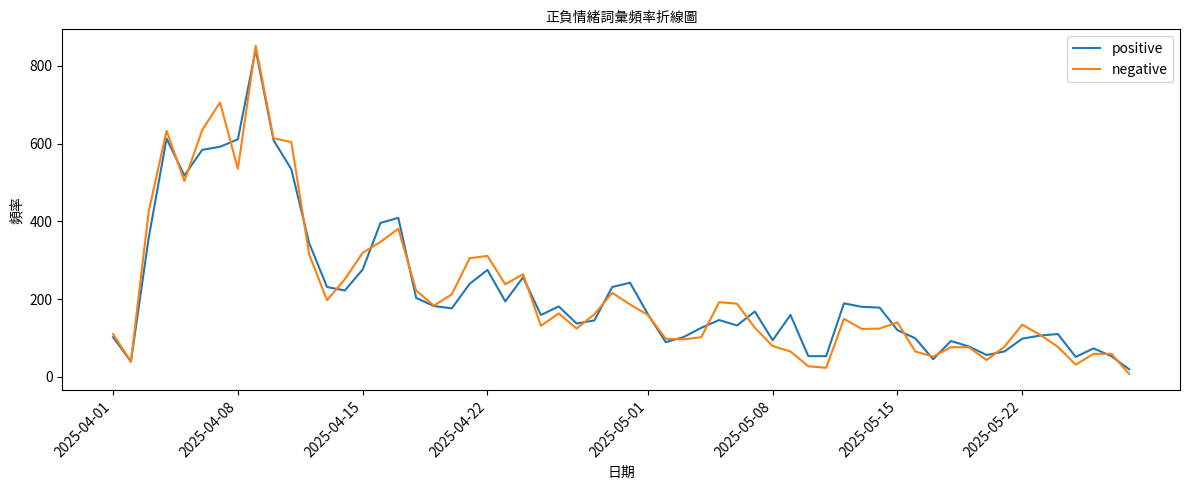

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates

# 設定字型
fprop = fm.FontProperties(fname=font_path)

# 畫圖
fig, ax = plt.subplots(figsize=(12, 5))  # 擴大畫布避免擁擠

ax.plot(pos["date"], pos['size'], color="tab:blue", label="positive")
ax.plot(neg["date"], neg['size'], color="tab:orange", label="negative")


# 自動調整日期文字避免重疊
fig.autofmt_xdate(rotation=45)

# 中文標題和圖例
plt.xlabel("日期", fontproperties=fprop)
plt.ylabel("頻率", fontproperties=fprop)
plt.title("正負情緒詞彙頻率折線圖", fontproperties=fprop)
ax.legend(prop=fprop)

plt.tight_layout()
plt.show()


### 正負向情緒詞彙比例折線圖圖

In [ ]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("date")["size"].transform(lambda n: n / n.sum())
)
sentiment_count.head(10)

date sentiments  size     ratio
3   2025-04-01   negative   110  0.518868
4   2025-04-01   positive   102  0.481132
9   2025-04-02   negative    39  0.500000
10  2025-04-02   positive    39  0.500000
15  2025-04-03   negative   426  0.543367
16  2025-04-03   positive   358  0.456633
21  2025-04-04   negative   633  0.508026
22  2025-04-04   positive   613  0.491974
27  2025-04-05   negative   504  0.493151
28  2025-04-05   positive   518  0.506849

In [ ]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

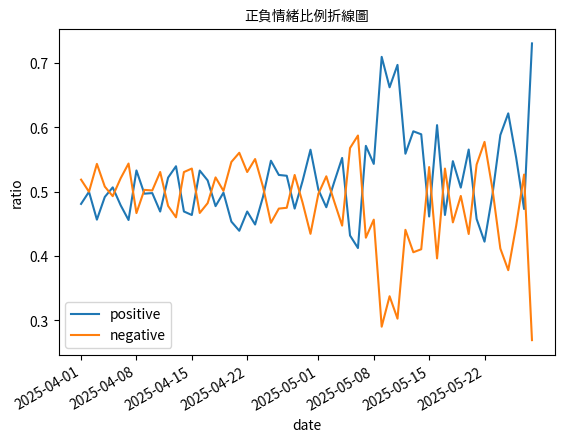

In [ ]:
fig, ax = plt.subplots()
colors = ["tab:blue", "tab:orange"]

# rolling_days = 100
ax.plot(pos["date"], pos["ratio"], color=colors[0])
ax.plot(neg["date"], neg["ratio"], color=colors[1])

plt.xlabel("date")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

### 正負向情緒分數折線圖

In [ ]:
#列出各頻論正負辭出現次數
mask = ~ptt_liwc_df['sentiments'].isna()
comment_sentiment_value = sentiment_count.pivot_table(index='date', columns='sentiments', values='size', fill_value=0).reset_index().rename_axis(None, axis=1)
comment_sentiment_value.head()

date  negative  positive
0  2025-04-01     110.0     102.0
1  2025-04-02      39.0      39.0
2  2025-04-03     426.0     358.0
3  2025-04-04     633.0     613.0
4  2025-04-05     504.0     518.0

In [ ]:
# sentiment 計算方式: positive - anger - anx - negative - sad
comment_sentiment_value["sentiment_value"] = (
    comment_sentiment_value["positive"]
    - comment_sentiment_value["negative"]
)
comment_sentiment_value.head()

date  negative  positive  sentiment_value
0  2025-04-01     110.0     102.0             -8.0
1  2025-04-02      39.0      39.0              0.0
2  2025-04-03     426.0     358.0            -68.0
3  2025-04-04     633.0     613.0            -20.0
4  2025-04-05     504.0     518.0             14.0

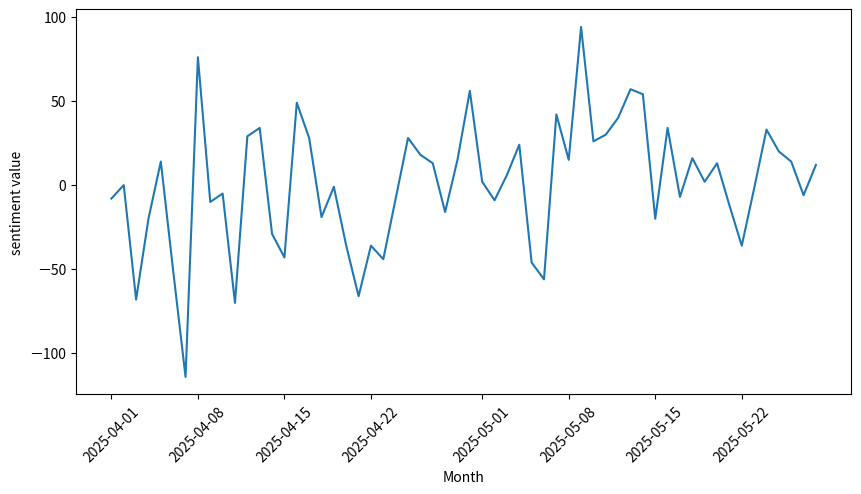

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the data
ax.plot(comment_sentiment_value['date'], comment_sentiment_value["sentiment_value"])
ax.set_xlabel('Month')
ax.set_ylabel('sentiment value')
# Rotate x-axis labels vertically
plt.xticks(rotation=45)
plt.show()

## 正負向代表的前十詞彙

In [ ]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)

word_count.head(10)

word sentiments  size
2349   風險     affect   676
2351   風險   negative   676
2350   風險        anx   676
2027   衝擊   negative   657
2026   衝擊     affect   657
779    希望   positive   618
778    希望     affect   618
2298   降低     affect   506
2299   降低   negative   506
2300   降低        sad   506

In [ ]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos.head(15)

word sentiments  size
779    希望   positive   618
2260   重要   positive   477
1203   支持   positive   402
2041   解決   positive   389
184    信心   positive   310
701    安全   positive   282
178    保護   positive   281
1438   決定   positive   266
1762   確定   positive   240
1726   相信   positive   234
2345   願意   positive   227
292    公平   positive   222
1267   智慧   positive   210
1082   承諾   positive   203
1811   簡單   positive   194

In [ ]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg.head(15)

word sentiments  size
2351   風險   negative   676
2027   衝擊   negative   657
2299   降低   negative   506
608    壓力   negative   484
2034   衰退   negative   431
569    嚴重   negative   273
2095   警告   negative   251
1195   擔心   negative   241
226    債務   negative   218
601    報復   negative   214
1045   戰爭   negative   210
1198   擔憂   negative   205
907    恐慌   negative   189
691    威脅   negative   173
1169   損失   negative   172

<ipython-input-41-1130120372>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
<ipython-input-41-1130120372>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

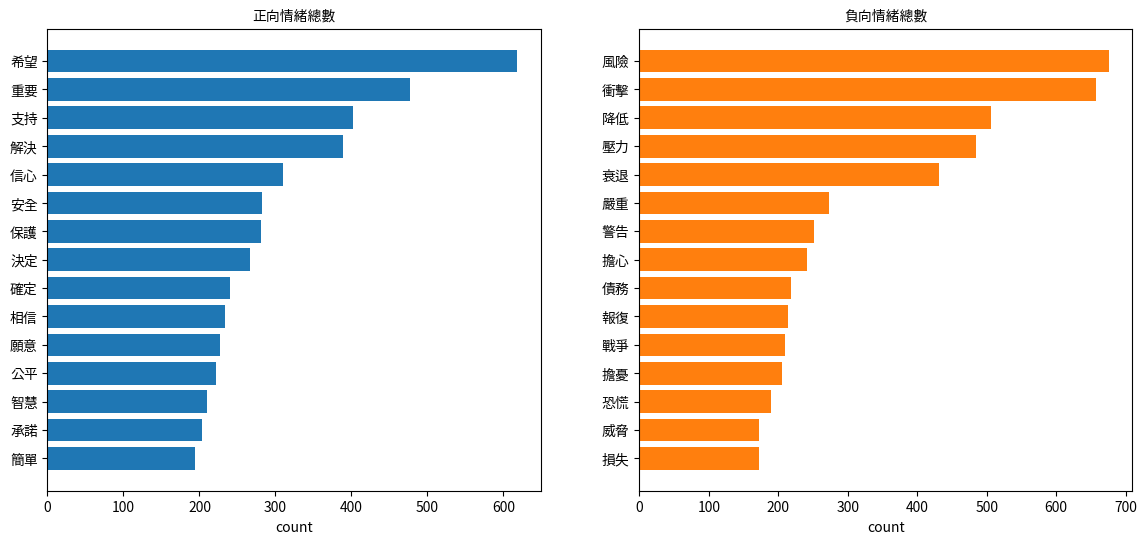

In [ ]:
pos = word_of_pos.head(15).sort_values(["size"], ascending=True)
neg = word_of_neg.head(15).sort_values(["size"], ascending=True)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 調整畫布大小


ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

# 2. 分類模型的訓練流程
### 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標。

In [ ]:
noStop_df_2.columns

Index(['artTitle', 'artDate', 'artContent', 'word'], dtype='object')

In [ ]:
data = noStop_df_2.copy()

# 建立簡單情緒標籤
def label_sentiment(text):
    if any(word in text for word in ["賺", "買", "笑", "好", "讚"]):
        return "Positive"
    elif any(word in text for word in ["賠", "跌", "死", "怒", "爛"]):
        return "Negative"
    else:
        return "Neutral"

data = noStop_df_2.copy()
data["sentiments"] = data["artContent"].apply(label_sentiment)


# 合併詞為一段文字（模擬 Dcard 結構）
grouped = data.groupby(["artTitle", "sentiments"])["word"].apply(lambda x: " ".join(x)).reset_index()
grouped = grouped.rename(columns={"word": "words", "sentiments": "artCatagory"})

# 分類資料切分
from sklearn.model_selection import train_test_split
X = grouped["words"]
y = grouped["artCatagory"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)


用 noStop_df_2 做分類，搭配簡單情緒判斷（或一小部分人工標記），後續再優化標籤品質。

這樣可以：

保有 3000 多筆資料

是以「實際原文內容」來預測情緒，比 LIWC 更具應用價值

In [ ]:
# 看一下各個資料集切分的比例，應該要一致
print(
    f"raw data percentage :\n{grouped['artCatagory'].value_counts(normalize=True) * 100}"
)
print(f"\ntrain percentage :\n{y_train.value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{y_test.value_counts(normalize=True) * 100}")


raw data percentage :
artCatagory
Positive    64.285714
Neutral     23.406593
Negative    12.307692
Name: proportion, dtype: float64

train percentage :
artCatagory
Positive    63.997907
Neutral     23.704867
Negative    12.297227
Name: proportion, dtype: float64

test percentage :
artCatagory
Positive    64.957265
Neutral     22.710623
Negative    12.332112
Name: proportion, dtype: float64


###將文章轉為 DTM

DTM(document term matrix) :
+ 將不同的文章 (document) 以文章中出現過的字詞(term)表示
    + row 是document (文件)
    + column 是字詞 (term)
    + row 內的數字是出現的字數

DTM裡面的值可以有不同的表示方法
+ (1) 依據詞頻 (classic BoW)
    + 用 `CountVectorizer()`
    + unigrams and bigrams
    + [sklearn.feature_extraction.text.CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ (2) 依據tfidf (advanced variant of BoW)
    + 篩選出現次數大於10的字
    + 用 `TfidfVectorizer()`
    + [sklearn.feature_extraction.text.TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)
+ 常用參數介紹
    + max_features: 取 詞頻 / tfidf 前多少的字

###套入正式的資料集

模型訓練範例: logistic regression + cv tokenizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
print(vectorizer)


CountVectorizer(max_features=1000)


In [ ]:
X_train.head()

1628    川普 關稅 大刀 保健品 海嘯 藥廠 恐受 重擊 20250406 1544 繼續 往下 閱...
1876    沃爾瑪 壓力 漲價 川普 怒嗆 給我 吞下去 正安 報導 發佈 時間 20250518 18...
661     國家 知道 戰爭 最後 好處 一堆 戰爭 實力 強的 判斷 實力 利益 反擊 實力 往往 民...
2514    川普 關稅 今年 到期 債務 九兆 印九兆給 關稅 不一定 100 得到 東西 美國 印鈔 ...
2225    蘋鏈 解套 CBP 公布 關稅 豁免 編碼 99030132 報關 關鍵 美國 中國 輸美 ...
Name: words, dtype: object

In [ ]:
# 將訓練集文字轉為 Bag-of-Words 向量
vec_train = vectorizer.fit_transform(X_train)

# 取得詞彙表
vocabulary = vectorizer.get_feature_names_out()

# 轉換成 DataFrame 來觀察稀疏矩陣的內容
Count_df = pd.DataFrame(columns=vocabulary, data=vec_train.toarray())
Count_df


000  04  100  1000  11  12  125  13  14  145  ...  高於  高盛  高達  高額  高點  \
0       0   0    0     0   0   0    0   0   0    0  ...   0   0   0   0   0   
1       0   0    0     0   0   0    0   0   0    0  ...   0   0   0   0   0   
2       0   0    0     0   0   0    0   0   0    0  ...   0   0   0   0   0   
3       0   0    1     0   0   0    0   0   0    0  ...   0   0   0   0   0   
4       0   0    0     0   2   1    0   0   0    1  ...   0   0   1   0   0   
...   ...  ..  ...   ...  ..  ..  ...  ..  ..  ...  ...  ..  ..  ..  ..  ..   
1906    0   0    1     0   0   1    0   0   0    0  ...   0   0   0   0   0   
1907    0   0    0     0   1   0    0   0   0    0  ...   0   0   0   0   0   
1908    0   0    0     0   0   0    0   0   0    0  ...   0   0   0   0   0   
1909    0   0    0     0   0   0    0   0   0    0  ...   0   0   0   0   0   
1910    2   0    0     0   0   0    0   0   0    0  ...   0   0   0   0   0   

      鮑爾  鴻海  黃仁  黃金  龐大  
0      0   0   0   0   0  
1      0   0   0   0   0  
2      0   0   0   0   0  
3      0   0   0   0   0  
4      0   0   0   0   0  
...   ..  ..  ..  ..  ..  
1906   0   1   0   0   0  
1907   0   0   0   0   0  
1908   4   0   0   0   0  
1909   0   0   0   0   0  
1910   0   0   0   0   0  

[1911 rows x 1000 columns]

In [ ]:
# 不需重新 `fit()` data，因前面已經 `fit()` 過了
# 只需將測試數據使用之前訓練好的 vectorizer 轉換為相同的特徵表示形式
vec_test = vectorizer.transform(X_test)

# 查看轉換後的維度
print(vec_train.shape)
print(vec_test.shape)


(1911, 1000)
(819, 1000)


In [ ]:
from sklearn.linear_model import LogisticRegression

# 建立分類器模型並訓練
clf = LogisticRegression()
clf.fit(vec_train, y_train)
clf


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
clf.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

使用train set訓練完後，用測試集試試看模型的分類結果

In [ ]:
# 模型預測標籤與機率
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# 顯示前 10 筆預測結果
print(y_pred[:10])


['Neutral' 'Negative' 'Positive' 'Neutral' 'Positive' 'Neutral' 'Positive'
 'Positive' 'Positive' 'Negative']


觀察看看模型輸出的類別機率

In [ ]:
# 檢查機率預測的 shape（樣本數 × 類別數）
print(y_pred_proba.shape)

# 查看第 1 筆測試資料的預測機率分布
y_pred_proba[0, :]


(819, 3)


array([0.00472672, 0.73549653, 0.25977675])

### 模型評估

In [ ]:
from sklearn.metrics import classification_report

# 顯示每一類的 precision / recall / F1-score
print(classification_report(y_test, y_pred, target_names=clf.classes_))


              precision    recall  f1-score   support

    Negative       0.27      0.25      0.26       101
     Neutral       0.32      0.32      0.32       186
    Positive       0.71      0.72      0.71       532

    accuracy                           0.57       819
   macro avg       0.43      0.43      0.43       819
weighted avg       0.57      0.57      0.57       819



輸出混淆矩陣

In [ ]:
from sklearn.metrics import confusion_matrix

# 取得類別名稱
classes = clf.classes_

# 混淆矩陣數據
cm = confusion_matrix(y_test, y_pred, labels=classes)
cm


array([[ 25,  18,  58],
       [ 26,  60, 100],
       [ 42, 109, 381]])

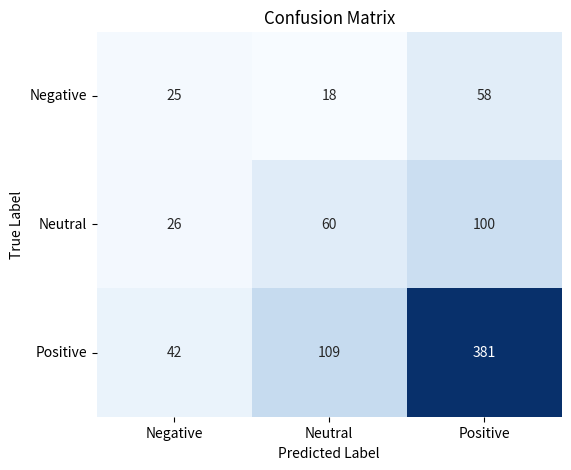

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 混淆矩陣
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
classes = clf.classes_

# 畫圖
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False,
            xticklabels=classes, yticklabels=classes)

ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

plt.yticks(rotation=0)
plt.show()


### TF-IDF
改使用 TF-IDF 的 DTM 來代表文章，訓練分類模型的效果。

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 建立 TF-IDF 向量
vectorizer = TfidfVectorizer(max_features=1000)

# 對訓練資料進行 fit_transform，測試資料只 transform（不能再fit）
vec_train = vectorizer.fit_transform(X_train)
vec_test = vectorizer.transform(X_test)

# 取得特徵名稱（字詞）
vocabulary = vectorizer.get_feature_names_out()

# 轉成 DataFrame 看向量長什麼樣
tfidf_df = pd.DataFrame(columns=vocabulary, data=vec_train.toarray())
tfidf_df


000   04       100  1000        11        12  125   13   14  \
0     0.000000  0.0  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0   
1     0.000000  0.0  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0   
2     0.000000  0.0  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0   
3     0.000000  0.0  0.177258   0.0  0.000000  0.000000  0.0  0.0  0.0   
4     0.000000  0.0  0.000000   0.0  0.107219  0.048879  0.0  0.0  0.0   
...        ...  ...       ...   ...       ...       ...  ...  ...  ...   
1906  0.000000  0.0  0.096672   0.0  0.000000  0.092726  0.0  0.0  0.0   
1907  0.000000  0.0  0.000000   0.0  0.182543  0.000000  0.0  0.0  0.0   
1908  0.000000  0.0  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0   
1909  0.000000  0.0  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0   
1910  0.252595  0.0  0.000000   0.0  0.000000  0.000000  0.0  0.0  0.0   

           145  ...   高於   高盛        高達   高額   高點        鮑爾        鴻海   黃仁  \
0     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   
1     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   
2     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   
3     0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   
4     0.057135  ...  0.0  0.0  0.054064  0.0  0.0  0.000000  0.000000  0.0   
...        ...  ...  ...  ...       ...  ...  ...       ...       ...  ...   
1906  0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.134896  0.0   
1907  0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   
1908  0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.380599  0.000000  0.0   
1909  0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   
1910  0.000000  ...  0.0  0.0  0.000000  0.0  0.0  0.000000  0.000000  0.0   

       黃金   龐大  
0     0.0  0.0  
1     0.0  0.0  
2     0.0  0.0  
3     0.0  0.0  
4     0.0  0.0  
...   ...  ...  
1906  0.0  0.0  
1907  0.0  0.0  
1908  0.0  0.0  
1909  0.0  0.0  
1910  0.0  0.0  

[1911 rows x 1000 columns]

In [ ]:
clf.fit(vec_train, y_train)
y_pred = clf.predict(vec_test)
y_pred_proba = clf.predict_proba(vec_test)

# results
## Accuracy, Precision, Recall, F1-score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Negative       0.36      0.04      0.07       101
     Neutral       0.44      0.17      0.24       186
    Positive       0.67      0.93      0.78       532

    accuracy                           0.65       819
   macro avg       0.49      0.38      0.36       819
weighted avg       0.58      0.65      0.57       819



### CV
cross_validate：

- 返回多種指標的結果，包括 f1_macro、recall_macro 和 precision_macro，並能返回每折訓練和測試的時間、模型等詳細信息。

- 更適合用於綜合評估模型的性能並返回模型本身。

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import classification_report
from pprint import pprint
import numpy as np

# 文字向量轉換
vectorizer = TfidfVectorizer(max_features=1000)
vec_train = vectorizer.fit_transform(X_train)

# 分類器
clf = LogisticRegression(max_iter=1000)

# -------- (1) CV 效能指標 --------
scores = cross_validate(
    clf,
    vec_train,
    y_train,
    cv=5,
    scoring=("f1_macro", "recall_macro", "precision_macro"),
    return_estimator=True
)

print("=== Cross-Validation Scores ===")
pprint(scores)
print("\n=== 平均分數 ===")
print(f"F1 (macro): {np.mean(scores['test_f1_macro']):.3f}")
print(f"Precision (macro): {np.mean(scores['test_precision_macro']):.3f}")
print(f"Recall (macro): {np.mean(scores['test_recall_macro']):.3f}")

# -------- (2) 分類報告（交叉驗證預測） --------
y_pred = cross_val_predict(clf, vec_train, y_train, cv=5)
print("\n=== Classification Report ===")
print(classification_report(y_train, y_pred))


=== Cross-Validation Scores ===
{'estimator': [LogisticRegression(max_iter=1000),
               LogisticRegression(max_iter=1000),
               LogisticRegression(max_iter=1000),
               LogisticRegression(max_iter=1000),
               LogisticRegression(max_iter=1000)],
 'fit_time': array([0.05343819, 0.05966282, 0.05980539, 0.07401299, 0.05736017]),
 'score_time': array([0.00859833, 0.00842857, 0.00942683, 0.00855923, 0.00885487]),
 'test_f1_macro': array([0.40790644, 0.37197136, 0.37069547, 0.35874225, 0.36765095]),
 'test_precision_macro': array([0.69689349, 0.70099546, 0.58512783, 0.41450077, 0.57650794]),
 'test_recall_macro': array([0.4038545 , 0.38636883, 0.38326981, 0.38287396, 0.38630315])}

=== 平均分數 ===
F1 (macro): 0.375
Precision (macro): 0.595
Recall (macro): 0.389

=== Classification Report ===
              precision    recall  f1-score   support

    Negative       0.77      0.04      0.08       235
     Neutral       0.48      0.19      0.27       453
    Po

## 比較不同模型效果

In [ ]:
# 定義模型訓練組合
## pipeline: 資料處理 vectorizer + 分類器 clf
## 由於 cross-validation 會自動將資料分成 train/test，因此 input 只要給 X, y 即可

def train_cv(vectorizer, clf, X, y):

    ## train classifier
    vec_X = vectorizer.fit_transform(X).toarray()

    ## get cv results
    cv_results = cross_validate(clf, vec_X, y, cv=5, return_estimator=True)
    y_pred = cross_val_predict(clf, vec_X, y, cv=5)
    y_pred_proba = cross_val_predict(clf, vec_X, y, cv=5, method="predict_proba")

    ## Accuracy, Precision, Recall, F1-score
    cls_report = classification_report(y, y_pred, output_dict=True)
    print(classification_report(y, y_pred))

    classes = cv_results['estimator'][0].classes_

    ## Plot confusion matrix
    cm = confusion_matrix(y, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(
        xlabel="Pred",
        ylabel="True",
        xticklabels=classes,
        yticklabels=classes,
        title= str(clf) + "Confusion matrix",
    )
    plt.yticks(rotation=0)

    clf.fit(vec_X, y)
    # return the model object
    return cls_report

因為TF-IDF的效果好一點，所以我們選擇使用TF-IDF來實作後面的模型。

              precision    recall  f1-score   support

    Negative       0.77      0.04      0.08       235
     Neutral       0.48      0.19      0.27       453
    Positive       0.67      0.94      0.78      1223

    accuracy                           0.65      1911
   macro avg       0.64      0.39      0.38      1911
weighted avg       0.63      0.65      0.57      1911



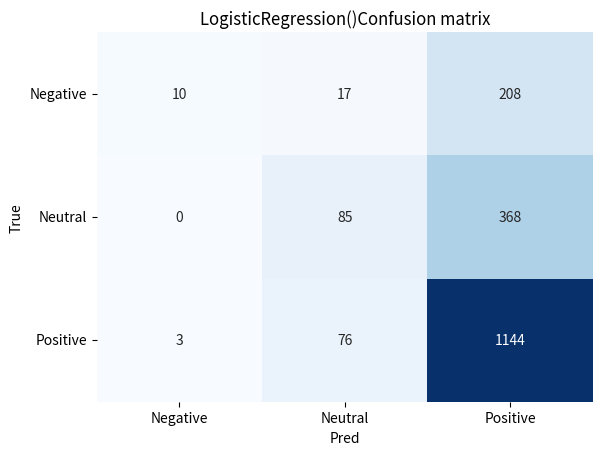

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
clf = LogisticRegression()
result = train_cv(vectorizer, clf, X_train, y_train)

正在訓練模型：Logistic Regression
              precision    recall  f1-score   support

    Negative       0.77      0.04      0.08       235
     Neutral       0.48      0.19      0.27       453
    Positive       0.67      0.94      0.78      1223

    accuracy                           0.65      1911
   macro avg       0.64      0.39      0.38      1911
weighted avg       0.63      0.65      0.57      1911

正在訓練模型：Decision Tree
              precision    recall  f1-score   support

    Negative       0.22      0.19      0.21       235
     Neutral       0.38      0.39      0.38       453
    Positive       0.69      0.70      0.70      1223

    accuracy                           0.56      1911
   macro avg       0.43      0.43      0.43      1911
weighted avg       0.56      0.56      0.56      1911

正在訓練模型：SVM
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00       235
     Neutral       0.51      0.08      0.13       453
    Positive    

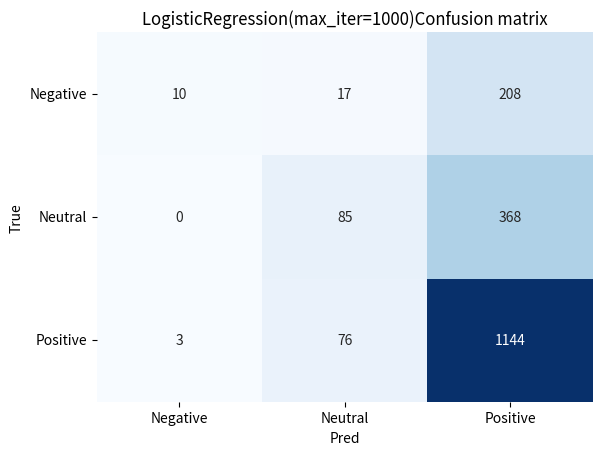

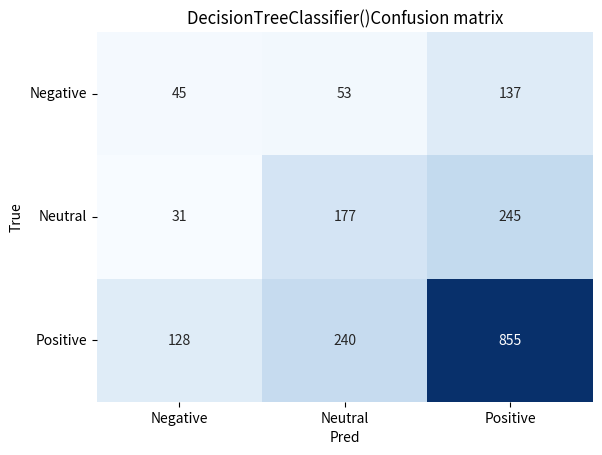

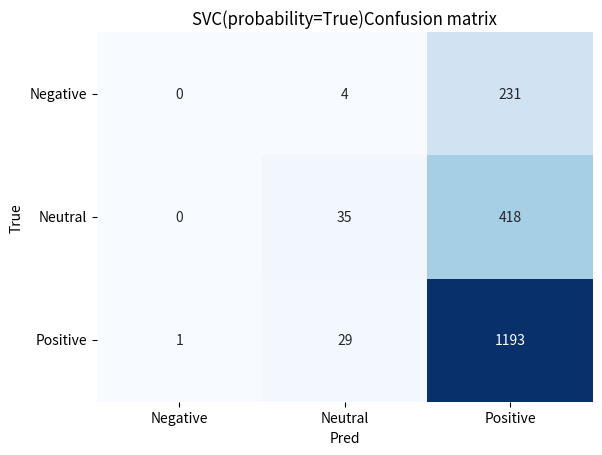

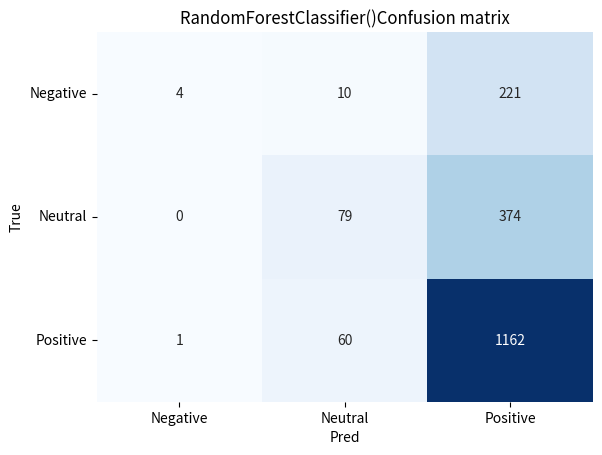

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

# 準備訓練資料（用 group 過後的社群媒體資料）
X = grouped["words"]
y = grouped["artCatagory"]

# 七三分訓練測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=777
)

# 定義多種模型
model_set = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': svm.SVC(probability=True),
    'Random Forest': RandomForestClassifier()
}

# 定義向量化器（TF-IDF）
vectorizer = TfidfVectorizer(max_features=1000)

# 存結果
result_set = {}

# 執行訓練
for name, model in model_set.items():
    print("="*100)
    print(f"正在訓練模型：{name}")
    result_set[name] = train_cv(vectorizer, model, X_train, y_train)
    print("="*100)


🔹 Logistic Regression
Positive 類預測很強（precision 0.67、recall 0.94）

Negative 幾乎無法識別（recall 0.04）

偏向多數類（造成低 macro recall）

🔹 Decision Tree
三類預測最平均

雖然正確率不高，但 macro F1 最穩定

適合類別不平衡問題（但可能 overfit）

🔹 SVM
完全放棄 Negative

只預測 Positive，導致 macro recall 與 F1 都低

SVM 本身對類別不平衡較敏感，建議用 class_weight='balanced'

🔹 Random Forest
和 Logistic 相似，偏向 Positive 類

Negative 類幾乎無法辨識



✅ 最佳 macro F1：Decision Tree (0.43)

🟨 雖然 Logistic 在 weighted 分數高，但在少數類別處理上不如 Decision Tree 平衡

## 主題模型
主題模型（Topic Modeling）是一種無監督學習技術，用於從大量文本中自動識別潛在的主題。本次使用LDA模型進行主題分析，並結合視覺化工具與情緒分析，探索文本資料中的主題分佈與情緒趨勢。

In [ ]:
# !pip uninstall -y numpy scipy gensim

# !pip install numpy==1.24.3 scipy==1.10.1 gensim==4.3.1

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 67.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.3 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.3 which is incompatible.


In [ ]:
# !pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.7/401.7 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fol

In [ ]:
import time
from functools import reduce
from collections import Counter
from pprint import pprint
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jieba
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import corpus2csc, corpus2dense, Sparse2Corpus

import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [ ]:
data = noStop_df_2.copy()

# 建立情緒標籤（或你自己的分類標籤）
data["sentiments"] = data["artContent"].apply(
    lambda x: "positive" if "賺" in x or "買" in x else ("negative" if "虧" in x or "賣" in x else "neutral")
)

# 每篇文章的詞彙集合（以 artTitle 模擬文章分群）
grouped = data.groupby("artTitle")["word"].apply(lambda x: list(x)).reset_index()
grouped = grouped.rename(columns={"word": "tokens"})  # 注意這邊我們改成 token list 給 gensim 用

grouped.head()


artTitle  \
0        Fw:[情報]川普稱將提出1兆美元國防預算   
1    Fw:[新聞]川普軟了？美國海關低調修改稅則陸晶片   
2         Re:3004豐達科飛機飛上天需要維修多   
3      Re:[心得]26歲賺到上億，卻死在這波暴跌！   
4  Re:[心得]上禮拜五把美股一鍵出清是賣在ㄚ呆股嗎QQ   

                                              tokens  
0  [作者, tony121010, 不給, 神奇, ID, 看板, Military, 新聞,...  
1  [作者, schwalbe, Preu, sche, Sparsamkeit, 看板, Go...  
2  [小弟, 技術, 零股, 回顧, 一下, 曾經, 研究, 標的, 分享, 一下, 感想, 上...  
3  [這篇, 股板, 適用, 一陣子, 隔壁班, 適用, 需要, 散熱, 水冷, 機櫃, 疊高,...  
4  [美股, 開盤, 聊聊, 心情, 三國演義, 裡面, 諸葛亮, 火燒, 上方, 糙機, 三小...

In [ ]:
print(noStop_df_2.columns)

Index(['artTitle', 'artDate', 'artContent', 'word'], dtype='object')


In [ ]:
print(grouped.columns)

Index(['artTitle', 'tokens'], dtype='object')


In [ ]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

# 1. 建立字典（每個詞彙對應一個編號）
dictionary = Dictionary(grouped["tokens"])

# 2. 建立語料庫（將每篇文章轉為詞袋格式）
corpus = [dictionary.doc2bow(text) for text in grouped["tokens"]]

# 3. 建立 LDA 模型
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=777)

# 4. 顯示主題關鍵字
lda_model.print_topics()


[(0,
  '0.012*"美國" + 0.012*"川普" + 0.009*"關稅" + 0.006*"市場" + 0.005*"中國" + 0.005*"台灣" + 0.005*"投資" + 0.004*"公司" + 0.003*"美債" + 0.003*"台股"'),
 (1,
  '0.023*"川普" + 0.016*"美國" + 0.012*"關稅" + 0.008*"中國" + 0.007*"市場" + 0.004*"經濟" + 0.004*"協議" + 0.004*"貿易" + 0.004*"股市" + 0.003*"政策"'),
 (2,
  '0.036*"美國" + 0.026*"關稅" + 0.024*"川普" + 0.013*"中國" + 0.007*"貿易" + 0.006*"國家" + 0.005*"政策" + 0.005*"經濟" + 0.004*"全球" + 0.004*"美元"'),
 (3,
  '0.023*"關稅" + 0.020*"美國" + 0.011*"川普" + 0.011*"台灣" + 0.006*"市場" + 0.006*"中國" + 0.006*"談判" + 0.005*"貿易" + 0.005*"經濟" + 0.005*"產業"'),
 (4,
  '0.015*"關稅" + 0.013*"美國" + 0.011*"中國" + 0.011*"川普" + 0.006*"市場" + 0.005*"to" + 0.004*"台灣" + 0.004*"and" + 0.004*"of" + 0.003*"in"')]

In [ ]:
docs = grouped["tokens"].to_list()
docs[0]


['作者',
 'tony121010',
 '不給',
 '神奇',
 'ID',
 '看板',
 'Military',
 '新聞',
 '川普',
 '稱將',
 '提出',
 '美元',
 '國防',
 '預算',
 '時間',
 'Tue',
 'Apr',
 '181241',
 '2025',
 '來源',
 'pitches',
 'trillion',
 'defense',
 'budget',
 'Colton',
 'Jones',
 'Apr',
 '2025',
 '以下',
 '機翻',
 '川普',
 '提出',
 '美元',
 '國防',
 '預算',
 '美國',
 '總統',
 '川普',
 '政府',
 '準備',
 '批准',
 '美元',
 '國防',
 '預算',
 '美國',
 '歷史',
 '最大',
 '國防',
 '預算',
 '全球',
 '威脅',
 '加劇',
 '情況',
 '確保',
 '軍事',
 '實力',
 '十分',
 '必要',
 '政府',
 '尚未',
 '提交',
 '2026',
 '財年',
 '正式',
 '預算',
 '申請',
 '總統',
 '演講',
 '證實',
 '實行',
 '撥款',
 '白宮',
 '正在',
 '推進',
 '大幅',
 '增加',
 '國防',
 '開支',
 '計畫',
 '完整',
 '預算',
 '提案',
 '預計',
 '將於',
 '今年',
 '季晚些',
 '發布',
 '國防部長',
 '皮特',
 '赫格塞斯',
 'Pete',
 'Hegseth',
 '一篇',
 '文章',
 '呼應',
 '川普',
 '信息',
 '寫道',
 '到來',
 'DeptofDefense',
 '預算',
 '寫道',
 '總統',
 'realDonaldTrump',
 '正在',
 '重建',
 '軍隊',
 '速度',
 'PS',
 '打算',
 '明智',
 '一分',
 '納稅人',
 '殺傷力',
 '戰備',
 '五角大廈',
 '白宮',
 '回應',
 '進一步',
 '要求',
 '分析',
 '人士',
 '預算',
 '推出',
 '階段',
 '進行',
 '一個僅',
 '包括',
 '數字',
 

建立並過濾詞彙表（dictionary），只保留特定條件的詞彙

    no_below=5 出現在少於 5 篇文章中的詞會被移除
    
    no_above=0.99 出現在超過 99% 文件中的詞會被移除

In [ ]:
dictionary = Dictionary(docs)

dictionary.filter_extremes(no_below=5, no_above=0.99)
print(dictionary)

Dictionary<9369 unique tokens: ['2025', '2026', '500', 'Apr', 'Military']...>


In [ ]:
from gensim.corpora import Dictionary

# 建立字典
dictionary = Dictionary(docs)

# 過濾詞彙：少於 5 篇文章出現的詞不要；出現在 99% 文件中的詞也移除
dictionary.filter_extremes(no_below=5, no_above=0.99)

# 查看字典狀態（詞彙數量）
print(dictionary)


Dictionary<9369 unique tokens: ['2025', '2026', '500', 'Apr', 'Military']...>


In [ ]:
from pprint import pprint

pprint(" ".join(grouped["tokens"].iloc[600]))


('改編 光年 之外 Passengers 中文 主題曲 凍結 時間 記住 望著 堅定 雙眼 也許 明天 面對 浩瀚 股海 微小 塵埃 漂浮 一片 無奈 '
 '美國 相遇 關稅 意外 川普 危難 相愛 也許 遙遠 任期 之外 我願 守候 未知 裡為 等待 沒想到 大盤 瘋狂 山崩 海嘯 根本 不想 股票 瘋狂 '
 '美國 製造 根本 重要')


In [ ]:
dictionary.doc2bow(grouped['tokens'].iloc[600])[:10]


[(49, 1),
 (67, 1),
 (86, 2),
 (192, 1),
 (204, 1),
 (245, 1),
 (597, 1),
 (608, 2),
 (631, 2),
 (713, 1)]

In [ ]:
# 1. 過濾字典
dictionary.filter_extremes(no_below=5, no_above=0.99)

# 2. 用 dictionary 過濾每篇文章的 tokens
corpus = [dictionary.doc2bow([w for w in doc if w in dictionary.token2id]) for doc in docs]

# 3. 訓練 LDA 模型
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=2024,
    passes=10,
    iterations=100
)
ldamodel.print_topics(num_words=10)


[(0,
  '0.051*"關稅" + 0.036*"美國" + 0.035*"川普" + 0.024*"中國" + 0.017*"貿易" + 0.011*"談判" + 0.009*"協議" + 0.008*"國家" + 0.008*"報導" + 0.008*"總統"'),
 (1,
  '0.020*"市場" + 0.013*"關稅" + 0.013*"美國" + 0.012*"川普" + 0.011*"經濟" + 0.010*"美元" + 0.008*"美債" + 0.007*"股市" + 0.007*"政策" + 0.007*"指數"'),
 (2,
  '0.057*"台灣" + 0.027*"關稅" + 0.019*"產業" + 0.015*"美國" + 0.015*"匯率" + 0.015*"談判" + 0.012*"升值" + 0.011*"對等" + 0.011*"政府" + 0.010*"台幣"'),
 (3,
  '0.050*"美國" + 0.031*"川普" + 0.026*"關稅" + 0.018*"中國" + 0.010*"台灣" + 0.010*"國家" + 0.007*"貿易" + 0.007*"經濟" + 0.006*"日本" + 0.005*"政府"'),
 (4,
  '0.039*"馬斯克" + 0.030*"特斯拉" + 0.016*"公司" + 0.014*"電力" + 0.011*"億元" + 0.010*"電動車" + 0.010*"今年" + 0.007*"市場" + 0.007*"股價" + 0.007*"產業"'),
 (5,
  '0.032*"to" + 0.027*"and" + 0.026*"of" + 0.023*"in" + 0.012*"on" + 0.012*"for" + 0.011*"that" + 0.009*"with" + 0.009*"US" + 0.009*"said"'),
 (6,
  '0.017*"川普" + 0.016*"關稅" + 0.013*"my" + 0.012*"from" + 0.012*"on" + 0.011*"Sent" + 0.009*"美國" + 0.009*"價格" + 0.009*"影響" + 0.009*"iPhone"'),
 (7,
  '

In [ ]:
topics = ldamodel.print_topics(num_words=10)  # 每個主題印出前 10 個關鍵詞
for idx, topic in topics:
    print(f"主題 {idx}：{topic}")


主題 0：0.051*"關稅" + 0.036*"美國" + 0.035*"川普" + 0.024*"中國" + 0.017*"貿易" + 0.011*"談判" + 0.009*"協議" + 0.008*"國家" + 0.008*"報導" + 0.008*"總統"
主題 1：0.020*"市場" + 0.013*"關稅" + 0.013*"美國" + 0.012*"川普" + 0.011*"經濟" + 0.010*"美元" + 0.008*"美債" + 0.007*"股市" + 0.007*"政策" + 0.007*"指數"
主題 2：0.057*"台灣" + 0.027*"關稅" + 0.019*"產業" + 0.015*"美國" + 0.015*"匯率" + 0.015*"談判" + 0.012*"升值" + 0.011*"對等" + 0.011*"政府" + 0.010*"台幣"
主題 3：0.050*"美國" + 0.031*"川普" + 0.026*"關稅" + 0.018*"中國" + 0.010*"台灣" + 0.010*"國家" + 0.007*"貿易" + 0.007*"經濟" + 0.006*"日本" + 0.005*"政府"
主題 4：0.039*"馬斯克" + 0.030*"特斯拉" + 0.016*"公司" + 0.014*"電力" + 0.011*"億元" + 0.010*"電動車" + 0.010*"今年" + 0.007*"市場" + 0.007*"股價" + 0.007*"產業"
主題 5：0.032*"to" + 0.027*"and" + 0.026*"of" + 0.023*"in" + 0.012*"on" + 0.012*"for" + 0.011*"that" + 0.009*"with" + 0.009*"US" + 0.009*"said"
主題 6：0.017*"川普" + 0.016*"關稅" + 0.013*"my" + 0.012*"from" + 0.012*"on" + 0.011*"Sent" + 0.009*"美國" + 0.009*"價格" + 0.009*"影響" + 0.009*"iPhone"
主題 7：0.023*"川普" + 0.014*"關稅" + 0.011*"股票" + 0.008*

In [ ]:
perplexity = ldamodel.log_perplexity(corpus)
perplexity


-7.637781859653197

In [ ]:
np.exp2(-perplexity)

199.15968930596753

In [ ]:
# npmi
NPMI_model_lda = CoherenceModel(model=ldamodel, texts=docs, coherence='c_npmi')
NPMI_lda = NPMI_model_lda.get_coherence()
print('這個主題模型的 PMI score: ', NPMI_lda)

這個主題模型的 PMI score:  0.03306882979538963


In [ ]:
NPMI_model_lda.get_coherence_per_topic()

[0.06431477529896021,
 0.019119289743243166,
 0.04021994633764627,
 0.012374038063407346,
 -0.015545889212932127,
 0.15921059138734925,
 -0.029736527126133092,
 0.024182884582918215,
 -0.006285105026579123,
 0.06283429390601616]

In [ ]:
t0 = time.time()

topic_num_list = np.arange(2, 8)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5 # 訓練次數
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

花費時間: 91.78717851638794 sec


In [ ]:
result = pd.DataFrame(result)
result

topic_num   perplexity       pmi
0          2  2462.873220 -0.054467
1          3  2352.774366 -0.025889
2          4  2232.691529  0.013133
3          5  2182.412045  0.004675
4          6  2154.472919  0.009939
5          7  2109.388533  0.015827

<Axes: xlabel='topic_num'>

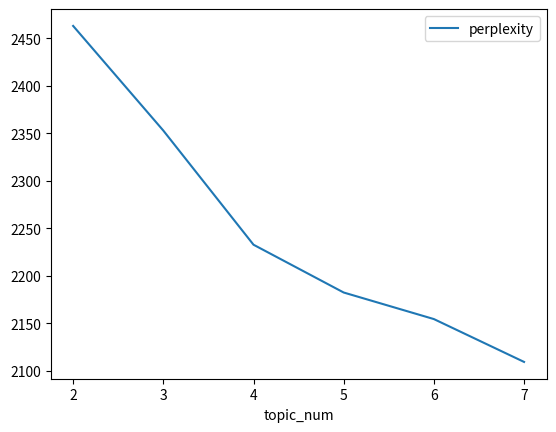

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

<Axes: xlabel='topic_num'>

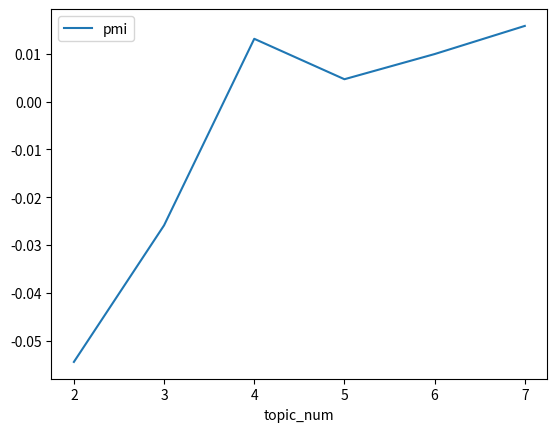

In [ ]:
result.plot.line(x='topic_num', y='pmi')

從 perplexity 來看：k=7 是表現最佳的模型。

從 coherence 來看：k=4 與 k=7 都是不錯的選擇，但 k=7 再略高一點。

主題數 = 7：在 perplexity 與 coherence 上同時有不錯表現
（或若你要強調語意品質，k=4 也是合理的選擇）

In [ ]:
best_model = LdaModel(
    corpus = corpus,
    num_topics = 7,
    id2word=dictionary,
    random_state = 1500,
    passes = 5 # 訓練次數
    )

In [ ]:
import gensim
gensim.__version__

'4.3.1'

In [ ]:
from pyLDAvis import gensim_models

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(best_model, corpus, dictionary)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.061739 -0.094772       1        1  29.581213
3     -0.081636 -0.036627       2        1  28.122029
1     -0.118797  0.130571       3        1  15.143988
6     -0.061223 -0.172693       4        1  12.204149
5     -0.150964  0.110575       5        1  10.031049
2      0.263180 -0.009664       6        1   2.697426
0      0.211178  0.072609       7        1   2.220147, topic_info=     Term         Freq         Total Category  logprob  loglift
117    中國  5192.000000   5192.000000  Default  30.0000  30.0000
161    晶片  1020.000000   1020.000000  Default  29.0000  29.0000
3019   to   493.000000    493.000000  Default  28.0000  28.0000
933    台股   820.000000    820.000000  Default  27.0000  27.0000
424    市場  2942.000000   2942.000000  Default  26.0000  26.0000
...   ...          ...           ...      ...      ...      ...
86     美國    73.105185  12413.288426   Topic7  -4.9038  -1.3270
381    投資    47.427190   1631.703863   Topic7  -5.3365   0.2694
1212   公司    39.355989   1376.673002   Topic7  -5.5230   0.2528
327    經濟    35.518025   2350.365344   Topic7  -5.6256  -0.3847
62     政府    32.805744   2012.674692   Topic7  -5.7051  -0.3090

[579 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
0         1  0.230469  2025
0         2  0.156545  2025
0         3  0.136977  2025
0         4  0.171764  2025
0         5  0.095666  2025
...     ...       ...   ...
2320      7  0.021368    鮑爾
6454      2  0.979122   麥當勞
4262      2  0.987525    麵包
3929      2  0.032507    黃仁
3929      4  0.961292    黃仁

[1533 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 7, 6, 3, 1])

# 3.embedding尋找相似詞、文章

## 套件們

In [ ]:
# !pip install numpy==1.24.3 scipy==1.10.1 gensim==4.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, 

In [ ]:
# !pip install jieba
# !pip install pandas

In [ ]:
import pandas as pd
import jieba
import jieba.analyse
import re
import numpy as np
from collections import defaultdict
import multiprocessing

from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec, KeyedVectors

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
import torch

from matplotlib.font_manager import fontManager
import plotly.express as px

sns.set_style("darkgrid")

In [ ]:
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-06-16 04:53:36--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.10.139, 142.251.10.100, 142.251.10.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.10.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-16 04:53:36--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  46.6MB/s    in 0.4s    

2025-06-16 04:5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 連接雲端讀取資料集

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/project/sna2025s_7_c3661dc516_4.csv")
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1          2  https://www.ptt.cc/bbs/Stock/M.1743468064.A.F2...   
2          3  https://www.ptt.cc/bbs/Stock/M.1743469067.A.DB...   

                             artTitle              artDate artPoster  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19    utn875   
1             [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02      rz2x   
2             [新聞]年賺11%！　達人揭「最強3檔ETF」  2025-04-01 08:57:45  galeolow   

  artCatagory                                         artContent  \
0       Stock  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
1       Stock  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   
2       Stock  原文標題：\n\n年賺11%！　達人揭「最強3檔ETF」\n\n原文連結：\nhttps:/...   

                                          artComment           e_ip  \
0  [{"cmtStatus": "噓", "cmtPoster": "FK6819", "cm...  111.71.82.129   
1  [{"cmtStatus": "推", "cmtPoster": "suzu1", "cmt...  61.220.173.25   
2  [{"cmtStatus": "噓", "cmtPoster": "Kobe5210", "...  36.230.61.187   

          insertedDate dataSource  
0  2025-04-01 01:35:07        ptt  
1  2025-04-04 19:29:49        ptt  
2  2025-04-04 19:29:49        ptt

## 前處理

In [ ]:
# 新增stopwords
with open('/content/drive/MyDrive/project/dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [ ]:
# 斷詞函式
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [ ]:
# 去除一些不需要的欄位
metaData = df.drop(['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

metaData = metaData[metaData['sentence'].apply(lambda x: isinstance(x, str))].copy()
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

metaData['word'] = metaData.sentence.apply(getToken)

metaData = metaData[metaData['word'].apply(len) > 0]

metaData.head(10)

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.949 seconds.
DEBUG:jieba:Loading model cost 0.949 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


artUrl  \
0  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
2  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
3  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
4  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
5  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
6  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
7  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
8  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
9  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   

                             artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
4  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
5  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
6  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
7  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
8  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
9  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent                 sentence  \
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  為何蓋廠投資額   
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  相比蓋廠省一半   
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                    答案很簡單   
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...             就是高雄五座廠只會用一半   
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  這篇講了五座廠無塵室面積萬平方公尺這如果全部做   
5  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  月產能可達萬片   
6  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                怎可能只花兆就搞定   
7  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                      事實上   
8  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...        整件事要和投資川普一起看原本的規劃   
9  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...              高雄五個廠足可容納加上   

                        word  
0                 [何蓋廠, 投資額]  
1               [相比, 蓋廠, 一半]  
2                   [答案, 簡單]  
3          [高雄, 五座, 只會用, 一半]  
4  [這篇講, 五座, 廠無塵室, 面積, 平方公尺]  
5               [產能, 可達, 萬片]  
6                   [只花, 搞定]  
7                       [事實]  
8            [整件事, 投資川普, 規劃]  
9          [高雄, 五個, 廠足, 可容納]

In [ ]:
# 參數形式手動加入停用字
stopwords_manual = ["億美", "心得", "內容", "原文", "表示", "未來", "評論", "連結", "目前", "標題", "指出", "10", "the", "問題", "商品", "企業", "記者", "措施", "認為", "現在", "20"]
stopWords.extend(stopwords_manual)

metaData_2 = metaData[~metaData['word'].isin(stopWords)]
metaData_2.head(10)

artUrl  \
0  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
2  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
3  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
4  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
5  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
6  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
7  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
8  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
9  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   

                             artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
4  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
5  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
6  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
7  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
8  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
9  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent                 sentence  \
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  為何蓋廠投資額   
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  相比蓋廠省一半   
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                    答案很簡單   
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...             就是高雄五座廠只會用一半   
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  這篇講了五座廠無塵室面積萬平方公尺這如果全部做   
5  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  月產能可達萬片   
6  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                怎可能只花兆就搞定   
7  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                      事實上   
8  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...        整件事要和投資川普一起看原本的規劃   
9  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...              高雄五個廠足可容納加上   

                        word  
0                 [何蓋廠, 投資額]  
1               [相比, 蓋廠, 一半]  
2                   [答案, 簡單]  
3          [高雄, 五座, 只會用, 一半]  
4  [這篇講, 五座, 廠無塵室, 面積, 平方公尺]  
5               [產能, 可達, 萬片]  
6                   [只花, 搞定]  
7                       [事實]  
8            [整件事, 投資川普, 規劃]  
9          [高雄, 五個, 廠足, 可容納]

## Word2Vec

In [ ]:
sents = metaData_2['word'].to_list()
bigrams = Phrases(sents,min_count=1, threshold=1000)
bigram_phrasers = Phraser(bigrams)
metaData_2['word_list_bigrams'] = list(bigram_phrasers[sents])

metaData_2.head()

artUrl  \
0  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
2  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
3  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
4  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   

                             artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
4  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent                 sentence  \
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  為何蓋廠投資額   
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  相比蓋廠省一半   
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                    答案很簡單   
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...             就是高雄五座廠只會用一半   
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  這篇講了五座廠無塵室面積萬平方公尺這如果全部做   

                        word          word_list_bigrams  
0                 [何蓋廠, 投資額]                 [何蓋廠, 投資額]  
1               [相比, 蓋廠, 一半]               [相比, 蓋廠, 一半]  
2                   [答案, 簡單]                   [答案, 簡單]  
3          [高雄, 五座, 只會用, 一半]          [高雄, 五座, 只會用, 一半]  
4  [這篇講, 五座, 廠無塵室, 面積, 平方公尺]  [這篇講, 五座, 廠無塵室, 面積, 平方公尺]

In [ ]:
word_freq = defaultdict(int)
# 計算詞頻
sents = metaData_2['word_list_bigrams'].tolist()
for sent in sents: # sent 中的每個句子
    for i in sent: # i 是句子中的每個字
        word_freq[i] += 1

In [ ]:
print(f"total unique words in sentences: {len(word_freq)}")
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

total unique words in sentences: 71393


['美國', '關稅', '中國', '川普', '原文', '美元', '台灣', '市場', '表示', '經濟']

In [ ]:
print(f"sentence number of corpus: {len(sents)}")
i = 0
for sent in sents:
    i = i + len(sent)
print(f"average length of sentences: {i/len(sents)}")

sentence number of corpus: 113565
average length of sentences: 4.423413903931669


In [ ]:
%env PYTHONHASHSEED=2025

env: PYTHONHASHSEED=2025


In [ ]:
cores = multiprocessing.cpu_count()
print(f"number of cores: {cores}")

number of cores: 2


## 建立模型

In [ ]:
# 建立模型
w2v_model = Word2Vec(sents,
                     min_count=30,# 小於30次tf的字會被刪除
                     window=2,# 往左右各2的距離
                     vector_size=128,# vector 的維度
                     sample=0.005,# 愈小的話，高tf的字會不容易被選到
                     alpha=0.001,# learning rate
                     min_alpha=0.0005, # 迭代到最小的learning rate，learning rate會慢慢下降至min_alpha
                     negative=0,
                     workers=cores-1, # 用的cpu資源
                     seed=8787,
                     sg = 1,# 0/1 是否使用skip gram
                     epochs= 30,
                     hs=1 , # hierarchical softmax
                     )

## 查看結果

和川普語意相似的詞

In [ ]:
w2v_model.wv.most_similar('川普',topn=10)

[('拜登', 0.685650110244751),
 ('但川普', 0.6137034893035889),
 ('在川普', 0.565231442451477),
 ('美國川普', 0.5470306873321533),
 ('普總統', 0.5424719452857971),
 ('明確', 0.5074098706245422),
 ('統川普', 0.5054925084114075),
 ('錯誤', 0.4964660406112671),
 ('特朗普', 0.49307042360305786),
 ('對川普', 0.46857115626335144)]

和台積電語意相似的詞

In [ ]:
w2v_model.wv.most_similar('台積電',topn=10)

[('積電', 0.8797780275344849),
 ('輝達', 0.6827497482299805),
 ('台積', 0.676612138748169),
 ('微軟', 0.6672083139419556),
 ('英特', 0.6453841328620911),
 ('業者', 0.637429416179657),
 ('阿拉伯', 0.6370994448661804),
 ('面板', 0.6158552169799805),
 ('大廠', 0.6006256937980652),
 ('應用', 0.5899739265441895)]

常出現不同的公司名稱，例如輝達、微軟，也會提到產業相關用詞例如面板、大廠

和川普、美國語意相似的詞

In [ ]:
w2v_model.wv.most_similar(['川普','美國'],topn=10)

[('拜登', 0.5684550404548645),
 ('但川普', 0.536812961101532),
 ('普總統', 0.49010029435157776),
 ('在川普', 0.482892245054245),
 ('特朗普', 0.4663473963737488),
 ('美國川普', 0.46505382657051086),
 ('補貼', 0.4396136999130249),
 ('貝森特', 0.42933332920074463),
 ('呼籲', 0.4283621311187744),
 ('效率', 0.4281688630580902)]

了解美國與台灣之間的關係

In [ ]:
# 計算兩個字之間的關係
w2v_model.wv.similarity("美國","台灣")

0.4295007

## 視覺化字詞間的關係

In [ ]:
# 取得所有的字
words = w2v_model.wv.key_to_index.keys()

In [ ]:
# 降維：利用PCA tSNE

def reduceDim(mat,method:str='PCA',dim:str=2,perplexity = 7,learning_rate = 400):

    method_dict = {
        "PCA":PCA(n_components=dim,iterated_power = 1000,random_state=0),
        "TSNE":TSNE(n_components=dim,random_state=0,perplexity=perplexity,learning_rate=learning_rate),
    }
    new_feat = method_dict[method].fit_transform(mat)

    return new_feat

In [ ]:
# 拿到list of words 的vector
def getVecs(model,words:list):
    vecs = []
    for i in words:
        vecs.append(model.wv[i])
    return np.vstack(vecs)

In [ ]:
# 擴展相似的字詞
def expandPosWord(model, words:list, top_n:int, split = True):

    if split == False:
        wp = model.wv.most_similar(words,topn = top_n)
        return wp
    expand = []

    for w in words:
        wp = model.wv.most_similar(w,topn = top_n)
        for i in wp:
            expand.append(i[0])

    return list(set(expand))

In [ ]:
# 畫出兩維的散佈圖
def plotScatter(vec_df):
    """
    vec_df: 字詞及其兩個維度的值
    """
    plt.figure(figsize=(15,15))
    fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
    plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
    plt.rcParams['font.size'] = '16'

    p = sns.scatterplot(x="dim1", y="dim2",
                  data=vec_df)
    for line in range(0, vec_df.shape[0]):
         p.text(vec_df["dim1"][line],
                 vec_df['dim2'][line],
                 '  ' + vec_df["word"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 weight='normal'
                ).set_size(15)
    plt.show()

# 畫出三維的散佈圖
def plotScatter3D(vec_df):
    vec_df['size'] = .5
    if 'color' not in vec_df.columns:
        vec_df['color'] = 'blue'
    fig = px.scatter_3d(
        vec_df,'dim1','dim2','dim3',text = 'word',width=800, height=800,color = 'color',size = 'size'

    )

    fig.show()

In [ ]:
sample_words = np.random.choice(list(words),300,replace=False).tolist()

feat = getVecs(model=w2v_model,words=sample_words)
print(feat.shape)
new_feat = reduceDim(feat,method='TSNE',perplexity=20,learning_rate = 800)
print(new_feat.shape)

(300, 128)
(300, 2)


In [ ]:
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
})

畫出二為散布圖

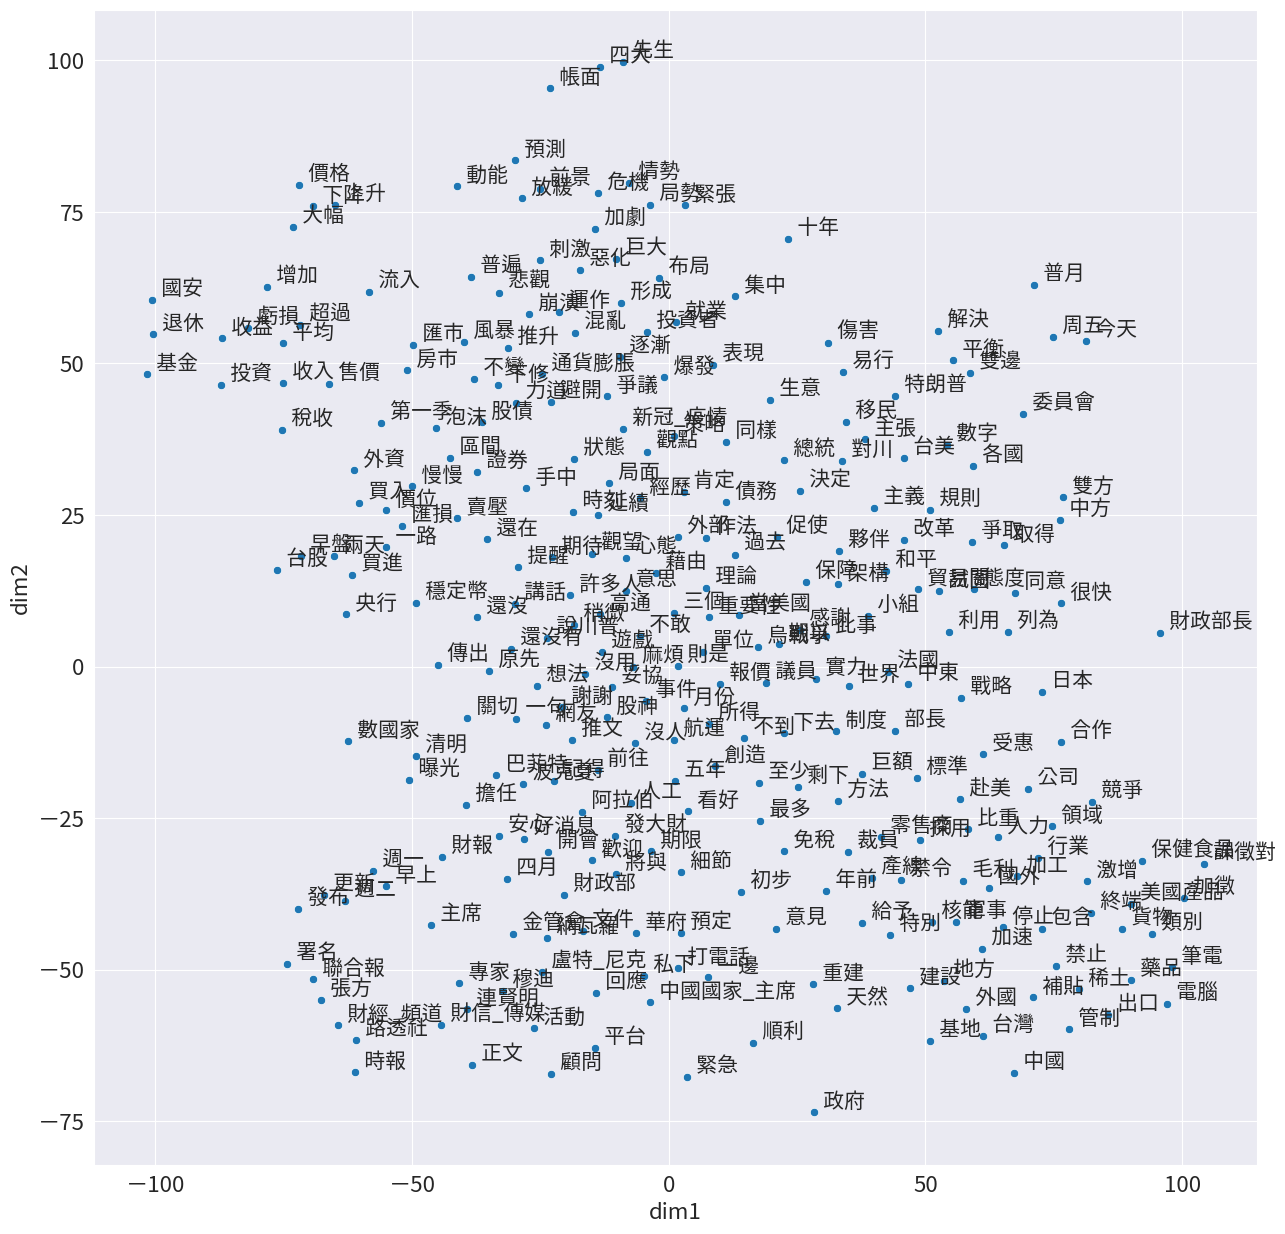

In [ ]:
plotScatter(word_df)

畫出三維分布圖
可以看得更清楚字詞間的分布差異

In [ ]:
new_feat = reduceDim(feat,dim = 3,method = 'PCA' )
print(new_feat.shape)
word_df = pd.DataFrame({
    "word":sample_words,
    "dim1":new_feat[:,0],
    "dim2":new_feat[:,1],
    "dim3":new_feat[:,2],
})
plotScatter3D(word_df)

(300, 3)


In [ ]:
# ! pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 52.9 MB/s eta 0:00:00


In [ ]:
# 分群
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# 只使用word vector 去分群
def cluster(X,method = 'kmeans',n = 2):

    method_dict = {
        'kmeans':KMeans(n_clusters=n, random_state=0),
        'kmedos':KMedoids(n_clusters=n, random_state=0)
    }
    method_dict[method].fit(X)
    result = method_dict[method].predict(X)
    return result

In [ ]:
new_feat = reduceDim(feat,method='PCA',dim = 20)
d3_feat = reduceDim(feat,method='PCA',dim = 3)
word_df = pd.DataFrame({
    "word":sample_words,
    "color":cluster(new_feat,n=4),
    "dim1":d3_feat[:,0],
    "dim2":d3_feat[:,1],
    "dim3":d3_feat[:,2],

})
plotScatter3D(word_df)

- 藍紫色區域多為與「政府政策與外交手段」相關的詞彙，語意上聚焦於行政單位、政策角色與貿易行動，如政府、總統、官員、協商、貿易夥伴、措施、代表等，呈現出政府在關稅政策中扮演的溝通與談判角色。

- 粉紫色區域多為與「產業與經濟運作」相關的詞彙，包含鋼鐵、設備、需求、產品、美國、高達、供應鏈等，這些詞彙指向川普關稅政策對製造業、進出口貿易與實體經濟的實質衝擊。

- 黃色區域為「貿易核心概念」詞彙，僅出現極少數但極具代表性的字詞如貿易本身，顯示這類詞彙在語意向量中距離其他類群較遠，卻又具高度概括性，常作為關鍵主題詞被獨立標示。

- 橘色區域的內容多為與「金融市場與股市反應」相關的詞彙，包含收益、資產、股市、建議、分析、收盤、美元、變動等，顯示在關稅政策實施後，市場分析與金融投資動態成為一個高度被關注的面向。

## embedding

In [ ]:
!pip uninstall -y transformers
!pip install transformers==4.35.0

Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.1/123.1 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 20.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.1
    Uninstalling tokenizers-0.21.1:
      Successfully uninstalled tokenizers-0.21.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
diffusers 0.33.1 

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.24.3

Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
diffusers 0.33.1 requires huggingface-hub>=0.27.0, but you have huggi

In [ ]:
!pip uninstall -y jax jaxlib
!pip install sentence-transformers transformers

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.17.3
    Uninstalling huggingface-hub-0.17.3:
      Successfully uninstalled huggingface-hub-0.17.3
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.14.1
    Uninstalling tokenizers-0.14.1:
      Successfully uninstalled tokenizers-0.14.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.0
    Uninstalling transformers-4.35.0:
      Successfully uninstalled transformers-4.35.0


In [ ]:
from sentence_transformers import SentenceTransformer, models, util

# 中文 bert-base-chinese
bert_ch = SentenceTransformer('google-bert/bert-base-chinese')

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/project/sna2025s_7_c3661dc516_4.csv")
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1          2  https://www.ptt.cc/bbs/Stock/M.1743468064.A.F2...   
2          3  https://www.ptt.cc/bbs/Stock/M.1743469067.A.DB...   

                             artTitle              artDate artPoster  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19    utn875   
1             [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02      rz2x   
2             [新聞]年賺11%！　達人揭「最強3檔ETF」  2025-04-01 08:57:45  galeolow   

  artCatagory                                         artContent  \
0       Stock  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
1       Stock  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   
2       Stock  原文標題：\n\n年賺11%！　達人揭「最強3檔ETF」\n\n原文連結：\nhttps:/...   

                                          artComment           e_ip  \
0  [{"cmtStatus": "噓", "cmtPoster": "FK6819", "cm...  111.71.82.129   
1  [{"cmtStatus": "推", "cmtPoster": "suzu1", "cmt...  61.220.173.25   
2  [{"cmtStatus": "噓", "cmtPoster": "Kobe5210", "...  36.230.61.187   

          insertedDate dataSource  
0  2025-04-01 01:35:07        ptt  
1  2025-04-04 19:29:49        ptt  
2  2025-04-04 19:29:49        ptt

## 資料前處理

In [ ]:
df_similar = df[['system_id','artTitle', 'artContent']]
# 處理 NaN 或非字串的情況
df_similar['artContent'] = df_similar['artContent'].apply(
    lambda x: re.sub('[^\u4e00-\u9fff]+', '', x) if isinstance(x, str) else ''
)

df_similar.head(5)

<ipython-input-10-4181185078>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_similar['artContent'] = df_similar['artContent'].apply(


system_id                            artTitle  \
0          1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴   
1          2             [新聞]稱沒聽過「骯髒15國」…川普對等關稅再   
2          3             [新聞]年賺11%！　達人揭「最強3檔ETF」   
3          4          Re:[新聞]稱沒聽過「骯髒15國」…川普對等關稅再   
4          5               [新聞]川普對等關稅失算？謝金河分析最開心   

                                          artContent  
0  為何蓋廠投資額相比蓋廠省一半答案很簡單就是高雄五座廠只會用一半這篇講了五座廠無塵室面積萬平方...  
1  原文標題稱沒聽過骯髒國川普對等關稅再變擬無差別課稅率原文連結發布時間記者署名工商時報吳慧珍原...  
2  原文標題年賺達人揭最強檔原文連結發布時間記者署名財經雲原文內容在川普關稅變數美國經濟衰退及通...  
3  骯髒國本來就不是川普講的骯髒國是美國財政部長貝森特日前接受專訪時首度提出我當時第一時間去查原...  
4  原文標題川普對等關稅失算謝金河分析最開心的是大陸尷尬真相曝光原文連結發布時間記者署名中時新聞...

In [ ]:
import torch
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cu124
12.4


In [ ]:
# 中文 bert-base-chinese

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
bert_ch = SentenceTransformer('google-bert/bert-base-chinese', device=device)

bert_ch.tokenizer.add_special_tokens({'pad_token': '[PAD]'})

Using device: cuda


0

In [ ]:
import torch
print("GPU 可用性：", torch.cuda.is_available())

GPU 可用性： True


In [ ]:
corpus_embeddings = bert_ch.encode(
    df_similar['artContent'],
    convert_to_tensor=True,
    batch_size=32
)

## 查看結果

和服飾業相關的文章

In [ ]:
query_num = 615 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: [新聞]亞洲服飾出口國遭課高關稅學者：美消費

 資料集中前五相似的文章:
[新聞]亞洲服飾出口國遭課高關稅學者：美消費 (Score: 1.0000)
[新聞]越南遭川普課46%對等關稅Nike、Hoka母 (Score: 0.9880)
[新聞]Temu和Shein：由於川普關稅銷美產品從下周開始漲價 (Score: 0.9865)
[新聞]Nike、Adidas鞋業巨頭向川普請求關稅豁免 (Score: 0.9854)
[新聞]華郵：美中關稅戰中小企業猶遇滅絕逾6 (Score: 0.9853)






和某協議相關的文章

In [ ]:
query_num = 555 # 指定文章

# Find the closest 5 sentences of the corpus for each query sentence based on cosine similarity
top_k = 5


query_embedding = bert_ch.encode(df_similar['artContent'][query_num], convert_to_tensor=True)

# We use cosine-similarity and torch.topk to find the highest 5 scores
cos_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
top_results = torch.topk(cos_scores, k=top_k)

print("\n\n======================\n\n")
print("Query:", df_similar['artTitle'][query_num])
print("\n 資料集中前五相似的文章:")

for score, idx in zip(top_results[0], top_results[1]):
    print(df_similar['artTitle'][idx.item()], "(Score: {:.4f})".format(score))

print("\n\n======================\n\n")





Query: Re:[新聞]「海湖莊園協議」？華爾街謠傳川普恐直

 資料集中前五相似的文章:
Re:[新聞]「海湖莊園協議」？華爾街謠傳川普恐直 (Score: 1.0000)
Re:[心得]為什麼要一直討論海湖莊園協議跟13.3? (Score: 0.9856)
[心得]經貿體系可能將會完全重建 (Score: 0.9850)
[請益]台幣升值,是為了買美債嗎? (Score: 0.9833)
Re:[新聞]川普想把台幣「弄到13.3」？專家驚呼： (Score: 0.9832)






# 4.BERT實作NER分析

## 套件

In [ ]:
!pip install ckip-transformers

In [ ]:
!pip install bertopic
!pip install scipy
!pip uninstall -y transformers sentence-transformers numpy scipy gensim
!pip install transformers sentence-transformers numpy scipy gensim torch --index-url https://download.pytorch.org/whl/cpu
!pip install transformers==4.41.0

Found existing installation: transformers 4.52.4
Uninstalling transformers-4.52.4:
  Successfully uninstalled transformers-4.52.4
Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0
Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Successfully uninstalled gensim-4.3.1
Looking in indexes: https://download.pytorch.org/whl/cpu
ERROR: Could not find a version that satisfies the requirement transformers (from versions: none)
ERROR: No matching distribution found for transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━

In [ ]:
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 22.2 MB/s eta 0:00:00


In [ ]:
# 1. 先移除舊版本
!pip uninstall -y transformers sentence-transformers

# 2. 安裝穩定版本（相容於大多數模型）
!pip install transformers==4.36.2 sentence-transformers==2.2.2

Found existing installation: transformers 4.41.0
Uninstalling transformers-4.41.0:
  Successfully uninstalled transformers-4.41.0
Found existing installation: sentence-transformers 4.1.0
Uninstalling sentence-transformers-4.1.0:
  Successfully uninstalled sentence-transformers-4.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 116.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 103.0 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=e92ba97d797436d8972279505857e6996c8f38485d9bfe66c8048a3dd7bc1148
  Stored in directory: /root/.cache/pip/wheels/ff/27/bf/ffba8b318b02d7f691a57084ee154e26ed24d012b0c7805881
Successfully built sentence-transformers
  Attempting uninstall: token

In [ ]:
!pip uninstall -y transformers sentence-transformers huggingface-hub
!pip install sentence-transformers

Found existing installation: transformers 4.36.2
Uninstalling transformers-4.36.2:
  Successfully uninstalled transformers-4.36.2
Found existing installation: sentence-transformers 2.2.2
Uninstalling sentence-transformers-2.2.2:
  Successfully uninstalled sentence-transformers-2.2.2
Found existing installation: huggingface-hub 0.32.4
Uninstalling huggingface-hub-0.32.4:
  Successfully uninstalled huggingface-hub-0.32.4
  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
Using cached sentence_transformers-4.1.0-py3-none-any.whl (345 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.8/514.8 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 80.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2


In [ ]:
import pandas as pd
import re
import numpy as np
from collections import defaultdict
import multiprocessing
import jieba
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager
from wordcloud import WordCloud

# 設定字體
fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [ ]:
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from ckip_transformers.nlp import CkipWordSegmenter, CkipPosTagger, CkipNerChunker
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/project/sna2025s_7_c3661dc516_4.csv')
df.head(3)

system_id                                             artUrl  \
0          1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1          2  https://www.ptt.cc/bbs/Stock/M.1743468064.A.F2...   
2          3  https://www.ptt.cc/bbs/Stock/M.1743469067.A.DB...   

                             artTitle              artDate artPoster  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19    utn875   
1             [新聞]稱沒聽過「骯髒15國」…川普對等關稅再  2025-04-01 08:41:02      rz2x   
2             [新聞]年賺11%！　達人揭「最強3檔ETF」  2025-04-01 08:57:45  galeolow   

  artCatagory                                         artContent  \
0       Stock  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...   
1       Stock  原文標題：\n稱沒聽過「骯髒15國」… 川普對等關稅再變 擬無差別課20％稅率\n\n原文連...   
2       Stock  原文標題：\n\n年賺11%！　達人揭「最強3檔ETF」\n\n原文連結：\nhttps:/...   

                                          artComment           e_ip  \
0  [{"cmtStatus": "噓", "cmtPoster": "FK6819", "cm...  111.71.82.129   
1  [{"cmtStatus": "推", "cmtPoster": "suzu1", "cmt...  61.220.173.25   
2  [{"cmtStatus": "噓", "cmtPoster": "Kobe5210", "...  36.230.61.187   

          insertedDate dataSource  
0  2025-04-01 01:35:07        ptt  
1  2025-04-04 19:29:49        ptt  
2  2025-04-04 19:29:49        ptt

## 資料前處理

In [ ]:
df = df.dropna(subset=['artContent']).reset_index(drop=True)

In [ ]:
# 去除一些不需要的欄位
metaData = df.drop(['system_id', 'artPoster', 'artCatagory', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)

# 只留下中文字
metaData['sentence'] = metaData['artContent'].str.replace(r'\n\n','。', regex=True)
metaData['sentence'] = metaData['sentence'].str.replace(r'\n','', regex=True)

metaData['sentence'] = metaData['sentence'].str.split("[,，。！!？?]{1,}")
metaData = metaData.explode('sentence').reset_index(drop=True)

# Convert to string before applying regex
metaData['sentence'] = metaData['sentence'].astype(str)
metaData['sentence'] = metaData['sentence'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))


metaData = metaData[metaData['sentence'].notna()]  # 去除 NaN
metaData = metaData[metaData['sentence'].str.strip() != ""]  # 去除空字串或全空白
metaData = metaData.reset_index(drop=True)

display(metaData.head(10))

artUrl  \
0  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
1  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
2  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
3  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
4  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
5  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
6  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
7  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
8  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   
9  https://www.ptt.cc/bbs/Stock/M.1743437421.A.CE...   

                             artTitle              artDate  \
0  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
1  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
2  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
3  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
4  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
5  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
6  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
7  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
8  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   
9  Re:[新聞]不顧卓揆親臨！台積電2奈米擴產董座缺席　5座廠花不到赴  2025-04-01 00:10:19   

                                          artContent                 sentence  
0  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  為何蓋廠投資額  
1  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  相比蓋廠省一半  
2  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                    答案很簡單  
3  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...             就是高雄五座廠只會用一半  
4  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...  這篇講了五座廠無塵室面積萬平方公尺這如果全部做  
5  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                  月產能可達萬片  
6  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                怎可能只花兆就搞定  
7  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...                      事實上  
8  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...        整件事要和投資川普一起看原本的規劃  
9  為何蓋廠投資額，相比蓋N3廠省一半???\n答案很簡單，就是高雄五座廠只會用一半\n\n這篇...              高雄五個廠足可容納加上

## Token classification

In [ ]:
ws_driver  = CkipWordSegmenter(model_name="ckiplab/bert-base-chinese-ws", device=0) # Word Segmenter斷詞
pos_driver = CkipPosTagger(model_name="ckiplab/bert-base-chinese-pos", device=0) # POS tagger 詞性標記
ner_driver = CkipNerChunker(model_name="ckiplab/bert-base-chinese-ner", device=0) # NER識別

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/407M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.86k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/407M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/407M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## 將CKIP套用到我們先前處理好的資料集

In [ ]:
# 以前2000筆資料作為範例
text = metaData['sentence'].tolist()[:2000]

# 執行處理
ws = ws_driver(text) # 斷詞
pos = pos_driver(ws) # POS
ner = ner_driver(text) # NER

# 將斷詞以及 pos 結果合在一起顯示
def pack_ws_pos_sentece(sentence_ws, sentence_pos):
   assert len(sentence_ws) == len(sentence_pos) # 確認斷詞和POS的長度相同
   res = []
   for word_ws, word_pos in zip(sentence_ws, sentence_pos):
      res.append(f"{word_ws}({word_pos})") # 合併在一起
   return "\u3000".join(res)

sentences, packed_sentences, entities = [], [], []

# 儲存結果
for sentence, sentence_ws, sentence_pos, sentence_ner in zip(text, ws, pos, ner):
   sentences.append(sentence)
   packed_sentences.append(pack_ws_pos_sentece(sentence_ws, sentence_pos))
   entities.append([str(entity) for entity in sentence_ner])

# 將結果存在一個 dataframe 中
ner_results = pd.DataFrame({
   'sentence': sentences,
   'packed_sentence': packed_sentences,
   'entities': entities
})

ner_results.head(10)

Inference: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it]


sentence                                    packed_sentence  \
0                  為何蓋廠投資額                          為何(D)　蓋(VC)　廠(Nc)　投資額(Na)   
1                  相比蓋廠省一半                  相比(VB)　蓋(VC)　廠(Nc)　省(VH)　一半(Neqa)   
2                    答案很簡單                               答案(Na)　很(Dfa)　簡單(VH)   
3             就是高雄五座廠只會用一半  就是(Cbb)　高雄(Nc)　五(Neu)　座(Nf)　廠(Nc)　只(Da)　會(D)　用...   
4  這篇講了五座廠無塵室面積萬平方公尺這如果全部做  這(Nep)　篇(Nf)　講(VE)　了(Di)　五(Neu)　座(Nf)　廠(Nc)　無塵...   
5                  月產能可達萬片                    月產能(Na)　可(D)　達(VJ)　萬(Neu)　片(Nf)   
6                怎可能只花兆就搞定                怎(D)　可能(D)　只(Da)　花兆(Na)　就(D)　搞定(VC)   
7                      事實上                                       事實(Na)　上(Ng)   
8        整件事要和投資川普一起看原本的規劃  整(Neqa)　件(Nf)　事(Na)　要(D)　和(P)　投資(VC)　川普(Nb)　一起...   
9              高雄五個廠足可容納加上      高雄(Nc)　五(Neu)　個(Nf)　廠(Nc)　足可(D)　容納(VJ)　加上(VC)   

                                            entities  
0                                                 []  
1  [NerToken(word='一半', ner='CARDINAL', idx=(5, 7))]  
2                                                 []  
3  [NerToken(word='高雄', ner='GPE', idx=(2, 4)), N...  
4  [NerToken(word='五', ner='CARDINAL', idx=(4, 5)...  
5   [NerToken(word='萬', ner='CARDINAL', idx=(5, 6))]  
6   [NerToken(word='兆', ner='CARDINAL', idx=(5, 6))]  
7                                                 []  
8    [NerToken(word='川普', ner='PERSON', idx=(7, 9))]  
9  [NerToken(word='高雄', ner='GPE', idx=(0, 2)), N...

In [ ]:
ner_results.head(10)

sentence                                    packed_sentence  \
0                  為何蓋廠投資額                          為何(D)　蓋(VC)　廠(Nc)　投資額(Na)   
1                  相比蓋廠省一半                  相比(VB)　蓋(VC)　廠(Nc)　省(VH)　一半(Neqa)   
2                    答案很簡單                               答案(Na)　很(Dfa)　簡單(VH)   
3             就是高雄五座廠只會用一半  就是(Cbb)　高雄(Nc)　五(Neu)　座(Nf)　廠(Nc)　只(Da)　會(D)　用...   
4  這篇講了五座廠無塵室面積萬平方公尺這如果全部做  這(Nep)　篇(Nf)　講(VE)　了(Di)　五(Neu)　座(Nf)　廠(Nc)　無塵...   
5                  月產能可達萬片                    月產能(Na)　可(D)　達(VJ)　萬(Neu)　片(Nf)   
6                怎可能只花兆就搞定                怎(D)　可能(D)　只(Da)　花兆(Na)　就(D)　搞定(VC)   
7                      事實上                                       事實(Na)　上(Ng)   
8        整件事要和投資川普一起看原本的規劃  整(Neqa)　件(Nf)　事(Na)　要(D)　和(P)　投資(VC)　川普(Nb)　一起...   
9              高雄五個廠足可容納加上      高雄(Nc)　五(Neu)　個(Nf)　廠(Nc)　足可(D)　容納(VJ)　加上(VC)   

                                            entities  
0                                                 []  
1  [NerToken(word='一半', ner='CARDINAL', idx=(5, 7))]  
2                                                 []  
3  [NerToken(word='高雄', ner='GPE', idx=(2, 4)), N...  
4  [NerToken(word='五', ner='CARDINAL', idx=(4, 5)...  
5   [NerToken(word='萬', ner='CARDINAL', idx=(5, 6))]  
6   [NerToken(word='兆', ner='CARDINAL', idx=(5, 6))]  
7                                                 []  
8    [NerToken(word='川普', ner='PERSON', idx=(7, 9))]  
9  [NerToken(word='高雄', ner='GPE', idx=(0, 2)), N...

In [ ]:
ner_results.to_pickle('ner_results.pkl')

In [ ]:
ner_results = pd.read_pickle('ner_results.pkl')

In [ ]:
ner_results.loc[30, 'entities']

["NerToken(word='美國', ner='GPE', idx=(7, 9))"]

## NER分析

In [ ]:
all_entities = []

# 遍歷每一列
for _, row in ner_results.iterrows():
    sentence = row['sentence']
    entity_list = row['entities']

    # 如果 entity_list 是有效的 list
    if isinstance(entity_list, list):
        for ent in entity_list:
            match = re.match(r"NerToken\(word='(.*?)', ner='(.*?)', idx=\((\d+), (\d+)\)\)", ent)
            if match:
                word, ner, idx_start, idx_end = match.groups()
                all_entities.append({
                    'sentence': sentence,
                    'word': word,
                    'ner': ner,
                    'idx': (int(idx_start), int(idx_end))
                })

# 建立展平後的 DataFrame
entities_df = pd.DataFrame(all_entities)

In [ ]:
entities_df

sentence word       ner       idx
0                     相比蓋廠省一半   一半  CARDINAL    (5, 7)
1                就是高雄五座廠只會用一半   高雄       GPE    (2, 4)
2                就是高雄五座廠只會用一半    五  CARDINAL    (4, 5)
3                就是高雄五座廠只會用一半   一半  CARDINAL  (10, 12)
4     這篇講了五座廠無塵室面積萬平方公尺這如果全部做    五  CARDINAL    (4, 5)
...                       ...  ...       ...       ...
1682                跟日韓也只有差而已    韓       GPE    (2, 3)
1683                    剛好休四天   四天      DATE    (3, 5)
1684              中國都沒辦法了何況台灣   中國       GPE    (0, 2)
1685              中國都沒辦法了何況台灣   台灣       GPE   (9, 11)
1686           台灣主動說不強制店家貼來源國   台灣       GPE    (0, 2)

[1687 rows x 4 columns]

In [ ]:
entities_df['ner'].unique()

array(['CARDINAL', 'GPE', 'QUANTITY', 'PERSON', 'ORG', 'WORK_OF_ART',
       'DATE', 'NORP', 'TIME', 'MONEY', 'LOC', 'ORDINAL', 'FAC',
       'PERCENT', 'EVENT', 'LAW'], dtype=object)

In [ ]:
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-06-16 05:27:17--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.130.101, 74.125.130.102, 74.125.130.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.130.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-16 05:27:17--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.194.132, 2404:6800:4003:c04::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.194.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  9.86MB/s    in 2.0s    

2025-06-16 05:2

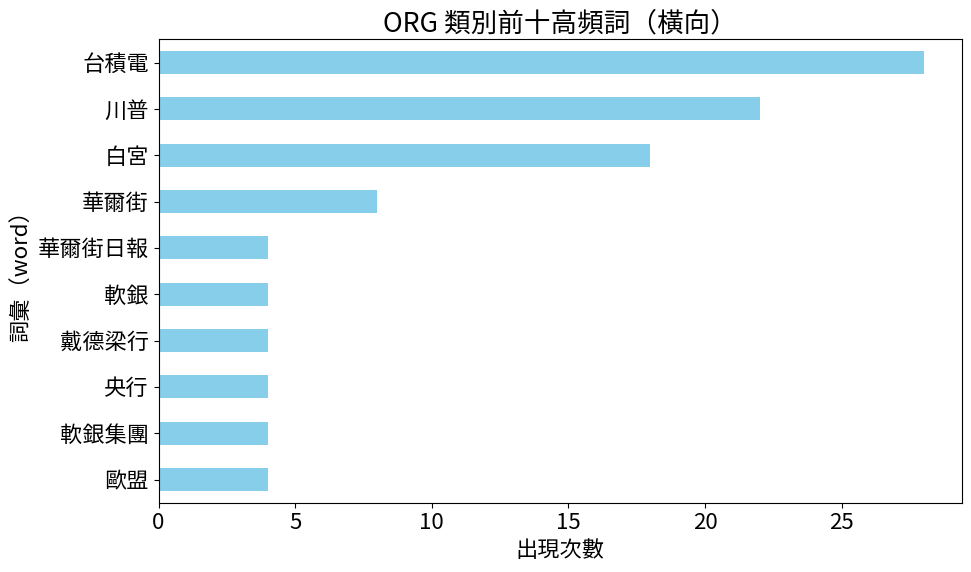

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 載入字體
font_path = 'TaipeiSansTCBeta-Regular.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'

# 繪製 ORG 詞彙長條圖
top_org_words = (
    entities_df[entities_df['ner'] == 'ORG']['word']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10, 6))
top_org_words.plot(kind='barh', color='skyblue')

plt.title("ORG 類別前十高頻詞（橫向）")
plt.xlabel("出現次數")
plt.ylabel("詞彙（word）")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

繪製ORG圖表，可以發現大家非常關注台積電，其中也有一些常見的公司例如軟銀

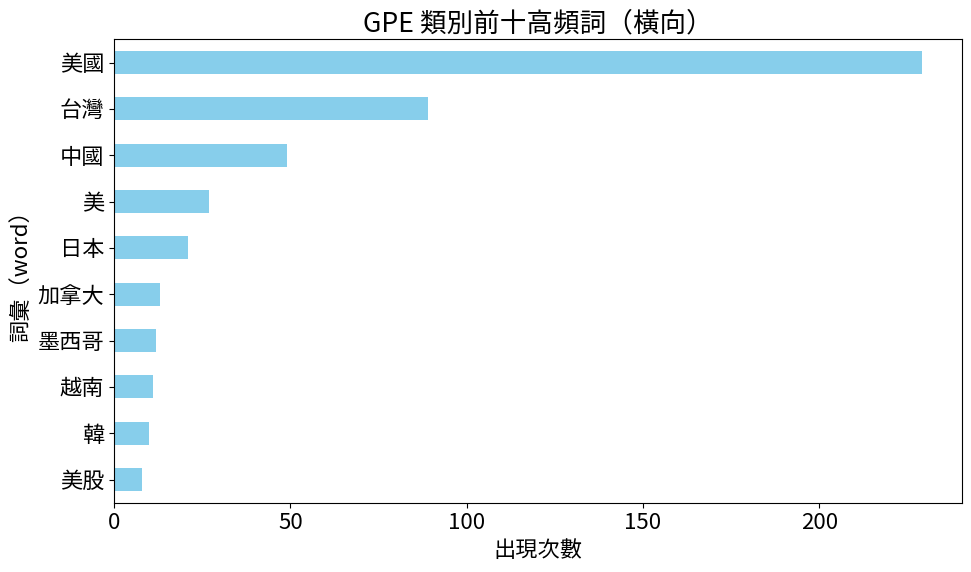

In [ ]:
# 繪製 GPE 詞彙長條圖
top_org_words = (
    entities_df[entities_df['ner'] == 'GPE']['word']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10, 6))
top_org_words.plot(kind='barh', color='skyblue')

plt.title("GPE 類別前十高頻詞（橫向）")
plt.xlabel("出現次數")
plt.ylabel("詞彙（word）")

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

繪製GPE圖表，除了主角美國和台灣以外，中國、日本的鄰近地區也很常被討論




# 5.網路圖

In [ ]:
raw_data = pd.read_csv('/content/sna2025s_7_c3661dc516_4.csv')
raw_data = raw_data[raw_data.artComment != '[]']
raw_data = raw_data.sample(round(raw_data.shape[0]/4), random_state=2024)
print(raw_data.shape)
raw_data.head()

(790, 11)


system_id                                             artUrl  \
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
2477       2478  https://www.ptt.cc/bbs/Stock/M.1745889287.A.91...   
1112       1113  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...   
1148       1149  https://www.ptt.cc/bbs/Stock/M.1744214654.A.BE...   
138         139  https://www.ptt.cc/bbs/Stock/M.1743687643.A.F2...   

                         artTitle              artDate     artPoster  \
171     Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58        CGDGAD   
2477  Re:[新聞]川普對台關稅出爐？中經院長：應在「15%  2025-04-29 09:14:45  dreambreaken   
1112      [新聞]快訊／中國再度出手反擊　宣布對美國產品  2025-04-09 20:35:01        anti87   
1148    Re:[新聞]「經濟學明明都有教！」美前財長警告川  2025-04-10 00:04:11         VANNN   
138      [新聞]川普對台課32%對等關稅依據為何中經院長  2025-04-03 21:40:41       myIDis7   

     artCatagory                                         artContent  \
171        Stock  這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
2477       Stock  台灣到現在還是用自己觀點在看事情\n誰不知道必須要談到比日韓低才是好事\n站在美國立場\n我...   
1112       Stock  原文標題：快訊／中國再度出手反擊　宣布對美國產品關稅升至84%\n原文連結：\nhttps:...   
1148       Stock  第一步已經發生\nhttps://www.managertoday.com.tw/artic...   
138        Stock  川普對台課32%對等關稅依據為何 中經院長：算法簡單又粗暴\n\n2025/4/3 14:0...   

                                             artComment            e_ip  \
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
2477  [{"cmtStatus": "→", "cmtPoster": "wr", "cmtCon...   60.250.75.123   
1112  [{"cmtStatus": "→", "cmtPoster": "apple123773"...  101.139.102.99   
1148  [{"cmtStatus": "推", "cmtPoster": "sony0223098"...   114.44.43.188   
138   [{"cmtStatus": "推", "cmtPoster": "popo3809490"...  114.39.124.243   

             insertedDate dataSource  
171   2025-04-04 19:31:17        ptt  
2477  2025-04-30 01:35:42        ptt  
1112  2025-04-11 01:43:22        ptt  
1148  2025-04-11 01:43:57        ptt  
138   2025-04-04 19:31:02        ptt

In [ ]:
raw_data = raw_data.head(100)
raw_data

system_id                                             artUrl  \
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
2477       2478  https://www.ptt.cc/bbs/Stock/M.1745889287.A.91...   
1112       1113  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...   
1148       1149  https://www.ptt.cc/bbs/Stock/M.1744214654.A.BE...   
138         139  https://www.ptt.cc/bbs/Stock/M.1743687643.A.F2...   
...         ...                                                ...   
2263       2264  https://www.ptt.cc/bbs/Stock/M.1745397112.A.DB...   
1178       1179  https://www.ptt.cc/bbs/Stock/M.1744222478.A.94...   
446         447  https://www.ptt.cc/bbs/Stock/M.1743846249.A.D7...   
576         577  https://www.ptt.cc/bbs/Stock/M.1743928008.A.29...   
1539       1540  https://www.ptt.cc/bbs/Stock/M.1744457516.A.BE...   

                         artTitle              artDate     artPoster  \
171     Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58        CGDGAD   
2477  Re:[新聞]川普對台關稅出爐？中經院長：應在「15%  2025-04-29 09:14:45  dreambreaken   
1112      [新聞]快訊／中國再度出手反擊　宣布對美國產品  2025-04-09 20:35:01        anti87   
1148    Re:[新聞]「經濟學明明都有教！」美前財長警告川  2025-04-10 00:04:11         VANNN   
138      [新聞]川普對台課32%對等關稅依據為何中經院長  2025-04-03 21:40:41       myIDis7   
...                           ...                  ...           ...   
2263       [新聞]川普軟了！喊話「不會對中國來硬的」：  2025-04-23 16:31:50        anti87   
1178                [心得]今天的盤中的關鍵點  2025-04-10 02:14:36      randy225   
446       Re:[請益]這次關稅危機會比2008更慘嗎？  2025-04-05 17:44:07      zebirlin   
576      [新聞]台股週一挫咧等？金管會傳備「18套劇本」  2025-04-06 16:26:44       hugh509   
1539       [新聞]就是不跟美國買！中美貿易戰升級大陸與  2025-04-12 19:31:53   justin531xx   

     artCatagory                                         artContent  \
171        Stock  這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
2477       Stock  台灣到現在還是用自己觀點在看事情\n誰不知道必須要談到比日韓低才是好事\n站在美國立場\n我...   
1112       Stock  原文標題：快訊／中國再度出手反擊　宣布對美國產品關稅升至84%\n原文連結：\nhttps:...   
1148       Stock  第一步已經發生\nhttps://www.managertoday.com.tw/artic...   
138        Stock  川普對台課32%對等關稅依據為何 中經院長：算法簡單又粗暴\n\n2025/4/3 14:0...   
...          ...                                                ...   
2263       Stock  原文標題：川普軟了！喊話「不會對中國來硬的」：關稅將遠低於145%\n原文連結：\nhttp...   
1178       Stock  個人認為是期待川普中午12:00前延長關稅\n\n\n但川普心意已決，到了12:00後  3...   
446        Stock  川普就是典型美國佬白人思維\n  這種人就是要硬起來抵抗\n  他才會尊敬你 然後給你條路走...   
576        Stock  原文標題：\n台股週一挫咧等？金管會傳備「18套劇本」救市 專家提4招解套\n\n原文連結：...   
1539       Stock  原文標題：\n\n就是不跟美國買！中美貿易戰升級 大陸與西班牙簽豬肉貿易協議\n\n原文連結...   

                                             artComment             e_ip  \
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...    218.35.245.93   
2477  [{"cmtStatus": "→", "cmtPoster": "wr", "cmtCon...    60.250.75.123   
1112  [{"cmtStatus": "→", "cmtPoster": "apple123773"...   101.139.102.99   
1148  [{"cmtStatus": "推", "cmtPoster": "sony0223098"...    114.44.43.188   
138   [{"cmtStatus": "推", "cmtPoster": "popo3809490"...   114.39.124.243   
...                                                 ...              ...   
2263  [{"cmtStatus": "→", "cmtPoster": "onolll", "cm...    101.138.20.52   
1178  [{"cmtStatus": "→", "cmtPoster": "dio0204", "c...    61.230.112.98   
446   [{"cmtStatus": "推", "cmtPoster": "kitune", "cm...   114.27.216.186   
576   [{"cmtStatus": "推", "cmtPoster": "ganlinlausu"...    114.46.72.132   
1539  [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...  123.195.113.114   

             insertedDate dataSource  
171   2025-04-04 19:31:17        ptt  
2477  2025-04-30 01:35:42        ptt  
1112  2025-04-11 01:43:22        ptt  
1148  2025-04-11 01:43:57        ptt  
138   2025-04-04 19:31:02        ptt  
...                   ...        ...  
2263  2025-04-24 01:39:20        ptt  
1178  2025-04-11 01:44:14        ptt  
446   2025-04-06 01:46:07        ptt  
576   2025-04-07 01:44:09        ptt  
1539  2025-04-13 01:40:04        ptt  

[100 rows x 11 columns]

# 發文者與留言者關係

取得留言者跟狀態（推）

In [ ]:
# parse comment
# 處理某篇文章的所有留言（取出留言者與狀態）
def getComtInfo(com):
  cmters,cmt_statuss = [],[]
  com = eval(com)
  for i in com:
    # print(i)
    cmters.append(i['cmtPoster'])
    cmt_statuss.append(i['cmtStatus'])
  return pd.Series([cmters, cmt_statuss])

raw_data[['artComter','artStatus']] = raw_data['artComment'].apply(lambda r: getComtInfo(r))
raw_data.head()

system_id                                             artUrl  \
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
2477       2478  https://www.ptt.cc/bbs/Stock/M.1745889287.A.91...   
1112       1113  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...   
1148       1149  https://www.ptt.cc/bbs/Stock/M.1744214654.A.BE...   
138         139  https://www.ptt.cc/bbs/Stock/M.1743687643.A.F2...   

                         artTitle              artDate     artPoster  \
171     Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58        CGDGAD   
2477  Re:[新聞]川普對台關稅出爐？中經院長：應在「15%  2025-04-29 09:14:45  dreambreaken   
1112      [新聞]快訊／中國再度出手反擊　宣布對美國產品  2025-04-09 20:35:01        anti87   
1148    Re:[新聞]「經濟學明明都有教！」美前財長警告川  2025-04-10 00:04:11         VANNN   
138      [新聞]川普對台課32%對等關稅依據為何中經院長  2025-04-03 21:40:41       myIDis7   

     artCatagory                                         artContent  \
171        Stock  這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
2477       Stock  台灣到現在還是用自己觀點在看事情\n誰不知道必須要談到比日韓低才是好事\n站在美國立場\n我...   
1112       Stock  原文標題：快訊／中國再度出手反擊　宣布對美國產品關稅升至84%\n原文連結：\nhttps:...   
1148       Stock  第一步已經發生\nhttps://www.managertoday.com.tw/artic...   
138        Stock  川普對台課32%對等關稅依據為何 中經院長：算法簡單又粗暴\n\n2025/4/3 14:0...   

                                             artComment            e_ip  \
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
2477  [{"cmtStatus": "→", "cmtPoster": "wr", "cmtCon...   60.250.75.123   
1112  [{"cmtStatus": "→", "cmtPoster": "apple123773"...  101.139.102.99   
1148  [{"cmtStatus": "推", "cmtPoster": "sony0223098"...   114.44.43.188   
138   [{"cmtStatus": "推", "cmtPoster": "popo3809490"...  114.39.124.243   

             insertedDate dataSource  \
171   2025-04-04 19:31:17        ptt   
2477  2025-04-30 01:35:42        ptt   
1112  2025-04-11 01:43:22        ptt   
1148  2025-04-11 01:43:57        ptt   
138   2025-04-04 19:31:02        ptt   

                                              artComter  \
171   [cuteSquirrel, talrasha, qunmie, qunmie, donis...   
2477  [wr, Feting, TRYING, TRYING, TRYING, testutw, ...   
1112  [apple123773, cuteSquirrel, intointo, a40494, ...   
1148  [sony0223098, necrophagist, starport, metam, a...   
138   [popo3809490, Colitas, Colitas, Colitas, a0000...   

                                              artStatus  
171   [推, →, →, →, →, 推, →, 推, →, →, →, →, 噓, →, →, ...  
2477  [→, →, →, →, →, 推, 推, 推, 推, 推, 推, →, 推, 推, →, ...  
1112  [→, 推, 推, 推, 推, 推, 推, 推, →, →, 推, →, 噓, →, 推, ...  
1148  [推, 推, 推, 推, →, →, →, 推, 推, 推, 推, →, →, →, 推, ...  
138             [推, →, →, →, 噓, →, →, →, →, →, →, →, →]

In [ ]:
raw_data = raw_data.head(500)
raw_data

system_id                                             artUrl  \
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
171         172  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...   
...         ...                                                ...   
1435       1436  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...   
1435       1436  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...   
1435       1436  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...   
1435       1436  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...   
1435       1436  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...   

                       artTitle              artDate   artPoster artCatagory  \
171   Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58      CGDGAD       Stock   
171   Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58      CGDGAD       Stock   
171   Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58      CGDGAD       Stock   
171   Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58      CGDGAD       Stock   
171   Re:[情報]川普:美國工業重生的一天迎接黃金時代  2025-04-04 02:32:58      CGDGAD       Stock   
...                         ...                  ...         ...         ...   
1435    [新聞]還我水來！川普怒控墨西哥違反水資源條約  2025-04-11 15:34:49  popo123456       Stock   
1435    [新聞]還我水來！川普怒控墨西哥違反水資源條約  2025-04-11 15:34:49  popo123456       Stock   
1435    [新聞]還我水來！川普怒控墨西哥違反水資源條約  2025-04-11 15:34:49  popo123456       Stock   
1435    [新聞]還我水來！川普怒控墨西哥違反水資源條約  2025-04-11 15:34:49  popo123456       Stock   
1435    [新聞]還我水來！川普怒控墨西哥違反水資源條約  2025-04-11 15:34:49  popo123456       Stock   

                                             artContent  \
171   這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
171   這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
171   這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
171   這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
171   這兩天一直在想，川普為何這麼執著美國製造?美國製造對美國有什麼好處?\n先從幾個檯面上的論點...   
...                                                 ...   
1435  新聞來源：udn\n網址\nhttps://udn.com/news/story/12437...   
1435  新聞來源：udn\n網址\nhttps://udn.com/news/story/12437...   
1435  新聞來源：udn\n網址\nhttps://udn.com/news/story/12437...   
1435  新聞來源：udn\n網址\nhttps://udn.com/news/story/12437...   
1435  新聞來源：udn\n網址\nhttps://udn.com/news/story/12437...   

                                             artComment            e_ip  \
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
171   [{"cmtStatus": "推", "cmtPoster": "cuteSquirrel...   218.35.245.93   
...                                                 ...             ...   
1435  [{"cmtStatus": "→", "cmtPoster": "kivan00", "c...  36.235.172.189   
1435  [{"cmtStatus": "→", "cmtPoster": "kivan00", "c...  36.235.172.189   
1435  [{"cmtStatus": "→", "cmtPoster": "kivan00", "c...  36.235.172.189   
1435  [{"cmtStatus": "→", "cmtPoster": "kivan00", "c...  36.235.172.189   
1435  [{"cmtStatus": "→", "cmtPoster": "kivan00", "c...  36.235.172.189   

             insertedDate dataSource     artComter artStatus  
171   2025-04-04 19:31:17        ptt  cuteSquirrel         推  
171   2025-04-04 19:31:17        ptt      talrasha         →  
171   2025-04-04 19:31:17        ptt        qunmie         →  
171   2025-04-04 19:31:17        ptt        qunmie         →  
171   2025-04-04 19:31:17        ptt    donis12345         →  
...                   ...        ...           ...       ...  
1435  2025-04-12 01:44:43        ptt    pttfrasier         推  
1435  2025-04-12 01:44:43        ptt     fpfun3688         推  
1435  2025-04-12 01:44:43  

依據每一筆留言展開

In [ ]:
raw_data = raw_data.explode(['artComter','artStatus'])
socail_data = raw_data[['artUrl','artPoster','artComter','artStatus']]
socail_data.head(10)

artUrl artPoster  \
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   

        artComter artStatus  
171  cuteSquirrel         推  
171      talrasha         →  
171        qunmie         →  
171        qunmie         →  
171    donis12345         →  
171        neil22         推  
171        jonsir         →  
171   Heedictator         推  
171      qwe78971         →  
171      qwe78971         →

In [ ]:
socail_data

artUrl   artPoster  \
171   https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      CGDGAD   
171   https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      CGDGAD   
171   https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      CGDGAD   
171   https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      CGDGAD   
171   https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      CGDGAD   
...                                                 ...         ...   
1435  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...  popo123456   
1435  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...  popo123456   
1435  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...  popo123456   
1435  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...  popo123456   
1435  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...  popo123456   

         artComter artStatus  
171   cuteSquirrel         推  
171       talrasha         →  
171         qunmie         →  
171         qunmie         →  
171     donis12345         →  
...            ...       ...  
1435    pttfrasier         推  
1435     fpfun3688         推  
1435        bigmao         →  
1435         jei01         →  
1435     milleniue         →  

[500 rows x 4 columns]

查看留言狀態

In [ ]:
socail_data.artStatus.unique()

array(['推', '→', '噓'], dtype=object)

建立邊的資料

In [ ]:
import random

# 發文者對文章
po_df = socail_data[['artPoster','artUrl']].drop_duplicates().rename(columns = {'artPoster':'src','artUrl':'dis'})

# sample 300 篇文章
random.seed(2024)
sample_url = random.choices(po_df.dis.unique().tolist(),k=300)
po_df = po_df[po_df.dis.isin(sample_url)]

# 留言者對文章，狀態為 weight
re_df = socail_data[['artComter','artUrl','artStatus']].rename(columns = {'artComter':'src','artUrl':'dis','artStatus':'weight'})
re_df = re_df[re_df.dis.isin(sample_url)]
re_df = re_df[~re_df['src'].isna()]
re_df.head()

src                                                dis weight
171  cuteSquirrel  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      推
171      talrasha  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      →
171        qunmie  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      →
171        qunmie  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      →
171    donis12345  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...      →

計算某留言者對文章的總評論分數
- 轉換邊的狀態 -> weight

In [ ]:
def convertStatus(s):
  if s == '推':
    return 2
  elif s == '→':
    return 1
  else :
    return -1
re_df['weight'] = re_df['weight'].map(convertStatus)
# 計算某位留言者對某篇文章的總分數
re_df = re_df.groupby(['src','dis']).sum().reset_index()
re_df

src                                                dis  weight
0       A80211ab  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2
1        Aerogel  https://www.ptt.cc/bbs/Stock/M.1744214654.A.BE...       3
2     AlarmAlarm  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...       2
3         AniOAO  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...      -1
4          Anikk  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...       1
..           ...                                                ...     ...
363       yu7038  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2
364     zebirlin  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2
365    zero00072  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       5
366       zgccgz  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2
367  zick8932511  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...       2

[368 rows x 3 columns]

In [ ]:
# 設定分數低的為紅色
def getColor(w):
  if w>0:
    return 'green'
  else:
    return 'red'
re_df['color'] = re_df.weight.map(getColor)
re_df

src                                                dis  weight  \
0       A80211ab  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2   
1        Aerogel  https://www.ptt.cc/bbs/Stock/M.1744214654.A.BE...       3   
2     AlarmAlarm  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...       2   
3         AniOAO  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...      -1   
4          Anikk  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...       1   
..           ...                                                ...     ...   
363       yu7038  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2   
364     zebirlin  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2   
365    zero00072  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       5   
366       zgccgz  https://www.ptt.cc/bbs/Stock/M.1744356891.A.33...       2   
367  zick8932511  https://www.ptt.cc/bbs/Stock/M.1744202106.A.67...       2   

     color  
0    green  
1    green  
2    green  
3      red  
4    green  
..     ...  
363  green  
364  green  
365  green  
366  green  
367  green  

[368 rows x 4 columns]

製作網路圖

In [ ]:
# 人為綠色節點
# po文為橘色節點

# 建立一個網路圖
netWork = pyvis.network.Network(notebook=True, cdn_resources='in_line',directed=True)
# 所有發文者＋留言者
person = list(set(po_df.src.unique().tolist()+re_df.src.unique().tolist()))
url = po_df.dis.unique().tolist()

# 加入節點（人）
netWork.add_nodes(
    nodes = person,
    value = [1 for i in range(len(person))],
    color = ['#66CDAA' for i in range(len(person))],
    title = person
)
# 加入節點（文章）
netWork.add_nodes(
    nodes = url,
    value = [2 for i in range(len(url))],
    color = ['#FFB366' for i in range(len(url))],
    title = url
)

# 加入邊（發文者 -> 文章）
for i in po_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color='grey')
# 加入邊（留言者 -> 文章），顏色為某發文者對該文章的總分（>0:綠; <=0:紅）
for i in re_df.to_numpy():
  netWork.add_edge(i[0],i[1],width = 2,color=i[3])

# 設定layout，圖節點之間的斥力
netWork.repulsion()

# netWork.show("./basic_netWork.html")
netWork.save_graph("./basic_netWork.html")
IPython.display.HTML('basic_netWork.html')

# 網友之間的關係

In [ ]:
pos_cmt = socail_data.copy()
pos_cmt = pos_cmt[~pos_cmt.artComter.isna()]
pos_cmt.head(10)

artUrl artPoster  \
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   
171  https://www.ptt.cc/bbs/Stock/M.1743705180.A.FD...    CGDGAD   

        artComter artStatus  
171  cuteSquirrel         推  
171      talrasha         →  
171        qunmie         →  
171        qunmie         →  
171    donis12345         →  
171        neil22         推  
171        jonsir         →  
171   Heedictator         推  
171      qwe78971         →  
171      qwe78971         →

In [ ]:
pos_cmt['score'] = pos_cmt['artStatus'].apply(lambda r: convertStatus(r))

# 某留言者對某發文者的總分
pos_cmt = pos_cmt.groupby(['artComter','artPoster']).sum('score').reset_index()
pos_cmt = pos_cmt[pos_cmt.score>=0]
pos_cmt = pos_cmt[pos_cmt.artComter != pos_cmt.artPoster]
# pos_cmt.score = 1
pos_cmt

artComter   artPoster  score
0       A80211ab  popo123456      2
1        Aerogel       VANNN      3
2     AlarmAlarm      anti87      2
4          Anikk      anti87      1
5         Anyotw      anti87      3
..           ...         ...    ...
363       yu7038  popo123456      2
364     zebirlin  popo123456      2
365    zero00072  popo123456      5
366       zgccgz  popo123456      2
367  zick8932511      anti87      2

[347 rows x 3 columns]

In [ ]:
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score').fillna(0)
mat

artPoster    CGDGAD  DogEggz  VANNN  anti87  dreambreaken  myIDis7  popo123456
artComter                                                                     
A80211ab        0.0      0.0    0.0     0.0           0.0      0.0         2.0
Aerogel         0.0      0.0    3.0     0.0           0.0      0.0         0.0
AlarmAlarm      0.0      0.0    0.0     2.0           0.0      0.0         0.0
Anikk           0.0      0.0    0.0     1.0           0.0      0.0         0.0
Anyotw          0.0      0.0    0.0     3.0           0.0      0.0         0.0
...             ...      ...    ...     ...           ...      ...         ...
yu7038          0.0      0.0    0.0     0.0           0.0      0.0         2.0
zebirlin        0.0      0.0    0.0     0.0           0.0      0.0         2.0
zero00072       0.0      0.0    0.0     0.0           0.0      0.0         5.0
zgccgz          0.0      0.0    0.0     0.0           0.0      0.0         2.0
zick8932511     0.0      0.0    0.0     2.0           0.0      0.0         0.0

[332 rows x 7 columns]

計算網友之間的分數矩陣
- mat: 有方向性，A -> B 分數與 B -> A 分數不一定一樣。
- mat_s: 無方向性（互動總分），A -> B 分數 +  B -> A 分數

In [ ]:
# 所有留言者與發文者
pers = np.unique(pos_cmt[['artComter', 'artPoster']])

# 建立評分矩陣（留言者對發文者分數）
# 取得所有人對於其他人的分數（有方向性）
# 矩陣中的值 mat[i][j] 代表使用者 pers[i]（留言者）對使用者 pers[j]（發文者）的評分，
    # 留言者和發文者之間的關係是有方向的（即，mat[i][j] 不一定等於 mat[j][i]）
mat = pd.pivot_table(pos_cmt,index = 'artComter', columns = 'artPoster' ,values='score' ).fillna(0)\
  .reindex(columns=pers, index=pers, fill_value=0).to_numpy()
print(mat.shape)

# 取得所有人與其他人互動分數總和（無方向，兩個方向分數相加）
# 矩陣中的每一對元素都對稱，即 mat_s[i][j] 等於 mat_s[j][i]
# 對稱矩陣中的值 mat_s[i][j] 表示使用者 pers[i] 與使用者 pers[j] 之間的互動總分。
    # 透過將 pers[i] 對 pers[j] 的評分和 pers[j] 對 pers[i] 的評分相加而得到的。
# np.tril(mat, -1): 生成一個下三角矩陣（包括主對角線下方的所有元素，但不包括主對角線上的元素）
# np.triu(mat, 1): 生成一個上三角矩陣（包括主對角線上方的所有元素，但不包括主對角線上的元素）
tri = (np.tril(mat,-1).T + np.triu(mat,1))
mat_s = tri+tri.T # 上三角和下三角都包括在內，但對角線是 0
mat_s


(339, 339)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

matPresentGraph()：用來將矩陣轉換為視覺化的網絡圖
- 利用 pyvis 來繪製網絡圖，並設定節點和邊的顏色。

In [ ]:
# 產生隨機的顏色，畫圖使用
def random_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())

def matPresentGraph(mat:np.array, node_id:list, node_type:list=None, node_value:list=None, directed=True, edge_color=None) -> pyvis.network.Network:
  # 有方向或無方向
  if directed != True:
    # 矩陣對稱
    if (mat == mat.transpose()).all():
      print('matrix is Symmetric')
    # 矩陣不對稱
    else:
      print('matrix is not Symmetric')

  # 設定節點的類別及顏色
  # 沒有分節點類別
  if node_type == None:
    c = random_color()
    node_colors = [c for i in range(len(node_id))]
    node_type = [" " for i in range(len(node_id))]
  # 有分節點類別
  else:
    node_color_map = {}
    for i in set(node_type):
      # 幫每個類別產生一個顏色
      while True:
        c = random_color()
        if c not in node_color_map.values():
          break
      node_color_map[i] = c
    node_colors = [node_color_map[i] for i in node_type]
  # print(node_colors)

  # 如果沒有給邊的顏色，隨機產生一個
  if edge_color == None:
    edge_color = random_color()

  # 如果沒有給 node 值，就都分配 1
  if node_value == None:
    node_value = [1 for i in range(len(node_id))]

  # 建立圖
  net = pyvis.network.Network(notebook=True, directed = directed, cdn_resources='in_line')

  titles_list = []
  for i ,j in zip(node_id,node_type):
    titles_list.append(str(i)+":"+str(j))

  net.add_nodes(
      nodes = node_id,
      value = node_value,
      label = node_id,
      title = titles_list,
      color = node_colors
  )

  for row in range(len(node_id)):
    for col in range(len(node_id)):
      if mat[row][col]>0.:
        net.add_edge(
            node_id[row],node_id[col],width = mat[row][col],color = edge_color,title = mat[row][col]
        )
  net.repulsion()
  return net


設定網友的節點類型（同時為發文、留言者 / 發文者 / 留言者）

In [ ]:
# 定義發文者（po）、評論者(cmt)、兩者兼具(both)
node_type = []

cmt_list = pos_cmt['artComter'].unique().tolist()
po_list = pos_cmt['artPoster'].unique().tolist()
both_list = list(set(cmt_list) & set(po_list))
for p in pers:
  if p in both_list:
    node_type.append('both')

  elif p in cmt_list:
    node_type.append('cmt')

  elif p in po_list:
    node_type.append('po')


In [ ]:
net = matPresentGraph(mat=mat, node_id=pers, node_type=node_type)
net.save_graph("./pers_netWork.html")
IPython.display.HTML('pers_netWork.html')

# Measures on node
- 目的：找出影響力大的節點（人）
- 方法：
    1. Eigenvector
    2. PageRank

## 計算 eigenvector centrality （無向圖）
- 概念：與你連接的人越重要，你也越重要(有影響力)
- 連到的節點重要性較高，也會貢獻較大的重要性

特徵向量中心性是一種衡量節點在網絡中重要性的方法，它基於連接節點的重要性計算每個節點的中心性值。經過歸一化處理後，這些中心性值可以更方便地進行比較和可視化。

In [ ]:
# nx.Graph(mat_s): 將對稱矩陣 mat_s 轉換為 NetworkX 的無向圖對象
# nx.eigenvector_centrality: 計算圖中每個節點的特徵向量中心性
# max_iter=10000: 演算法的最大迭代次數，以確保演算法收斂。 特徵向量中心性的計算是一個迭代過程，可能需要多次迭代才能達到穩定狀態。
eigenvec = np.array(list(nx.eigenvector_centrality(nx.Graph(mat_s),max_iter = 10000).values()))

# 將特徵向量中心性值歸一化到 [0, 1] 範圍內
eigenvec = (eigenvec-np.min(eigenvec))/(np.max(eigenvec)-np.min(eigenvec))

In [ ]:
# 計算中心分數的分位數用於分組
q = np.quantile(eigenvec,[.2,.4,.6,.8])
q

array([0.00147936, 0.01558046, 0.08068566, 0.08068566])

In [ ]:
node_value = []


for i in eigenvec:
  # 越重要分數越高
  if i > q[3]:
    node_value.append(35)
  elif i >q[2]:
    node_value.append(20)
  elif i>q[1]:
    node_value.append(15)
  elif i>q[0]:
    node_value.append(10)
  else:
    node_value.append(5)
net = matPresentGraph(mat = mat_s,node_id = pers,node_type = node_type,node_value = node_value,directed=False)
net.save_graph("./pers_eig_netWork.html")
IPython.display.HTML('pers_eig_netWork.html')


matrix is Symmetric


我們可以發現有評論的文章同時有多人評論的，重要程度愈高（節點越大）



## PageRank (有向圖)
- 在一個有向圖中，PageRank 值高的節點通常是那些被很多其他節點連結到的節點，或是被一些重要節點連結到的節點

In [ ]:
# Digraph 設定有向圖
# nx.DiGraph(mat): 使用 NetworkX 的 DiGraph 類別將矩陣 mat 轉換為有向圖物件。
# nx.pagerank(): 計算圖中每個節點的 PageRank 值
pagerank = np.array(list(nx.pagerank(nx.DiGraph(mat)).values()))
# pagerank = (pagerank-np.min(pagerank))/(np.max(pagerank)-np.min(pagerank))
pagerank

array([0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.02612063, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.01121737, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.04571936, 0.00161442,
       0.00161442, 0.00161442, 0.00161442, 0.00161442, 0.00161

In [ ]:
net = matPresentGraph(mat = mat,node_id = pers,node_type = node_type,node_value=(pagerank*1000).tolist())
net.save_graph("./pers_page_netWork.html")
IPython.display.HTML('pers_page_netWork.html')

可以看出indegree 較多，重要程度愈高